In [1]:
suppressPackageStartupMessages({
    library(RhpcBLASctl, quietly = T)
    library(doSNOW, quietly = T)
    
    library(splatter, quietly = T)
    
    library(scater, quietly = T)
    library(scran, quietly = T)
    library(bluster, quietly = T)
    
    library(BBmisc, quietly = T)
    
    library(liana, quietly = T)
    
    library(aricode, quietly = T)
    library(kBET, quietly = T)
    
    library(zellkonverter, quietly = T)
    
    library(reticulate, quietly = T)
    scanorama <- import('scanorama')
    scvi <- import("scvi", convert = FALSE)
})

source('./simulation_functions.r')

seed = 888
set.seed(seed)
data.path<-'/data/hratch/ccc_protocols/'
n.cores<-20

gpu<-T
par.score<-T # whether to parallelize communication scoring externally

if (!gpu){
    tensorly <- import('tensorly')
    tensorly$set_backend('pytorch')
}

RhpcBLASctl::blas_set_num_threads(n.cores)

# Functions

In [2]:
add.context.noise<-function(sim, context.noise, contexts){
    colData(sim)[['Context']]<-NULL
    for (i in seq_along(contexts)){
        context.cells<-contexts[[i]]
        noise.sim<-context.noise[[i]]

        counts(sim)[, context.cells] <- as.matrix(counts(sim)[, context.cells] + counts(noise.sim))
        colData(sim)[context.cells, 'Context']<-paste0('Context_', i)
    }
    return(sim)
}

scanorama.batch.correct<-function(sce.batch){

    # prep scanorama inputs - split expression objects by batch
    batches<-list()
    genes<-list()
    for (batch in unique(colData(sce.batch)$Batch)){
        cells.in.batch<-rownames(colData(sce.batch)[colData(sce.batch)$Batch == batch,])
        sce.singlebatch<-sce.batch[, cells.in.batch]

        batches[[batch]]<-t(assays(sce.singlebatch)$logcounts) # cells x genes
        genes[[batch]]<-as.list(rownames(sce.batch))
    }

    # do the batch correction 
    corrected.data <- scanorama$correct(unname(batches), unname(genes), return_dense=TRUE)

    # format into the sce
    genes<-corrected.data[[2]]
    corrected.data<-corrected.data[[1]]

    for (i in 1:length(corrected.data)){
        expr<-corrected.data[[i]]
        colnames(expr) <- genes
        rownames(expr) <- rownames(batches[[i]])
        corrected.data[[i]] <- t(expr)
    }
    corrected.data <- do.call(cbind, corrected.data)

    if (!identical(dim(corrected.data), dim(assays(sce.batch)$logcounts))){ # sanity check
        stop('Unexpected filters in scanorama batch correction')
    }
    corrected.data<-corrected.data[rownames(assays(sce.batch)$logcounts), colnames(assays(sce.batch)$logcounts)]
    assays(sce.batch)[['batch.corrected.counts']] <- corrected.data
    
    return(sce.batch)
}

scvi.batch.correct<-function(sce.batch, seed = 888){
    
    scvi$settings$seed = as.integer(seed)
    
    if (!gpu){
        scvi$settings$num_threads = as.integer(1)
        scvi$settings$dl_num_workers = as.integer(n.cores)
    }

    adata.batch<-zellkonverter::SCE2AnnData(sce.batch, X_name = 'counts') # adata with raw UMI counts as main
    reticulate::py_set_seed(as.integer(seed))
    scvi$model$SCVI$setup_anndata(adata.batch, layer = 'TrueCounts', batch_key = 'Batch')
    model = scvi$model$SCVI(adata.batch, n_layers = 2L, n_latent = 30L, gene_likelihood= "nb") # non-default args - 
    model$train()

    # library size and log1p make it similar to log(1+CPM) normalization, but with batch correction
    # batch corrected counts: https://discourse.scverse.org/t/how-to-extract-batch-corrected-expression-matrix-from-trained-scvi-vae-model/151
    corrected.data = model$get_normalized_expression(transform_batch = sort(unique(colData(sce.batch)$Batch)),
                                                    library_size = 1e6)
    corrected.data<-t(log1p(reticulate::py_to_r(corrected.data)))

    if (!identical(dim(corrected.data), dim(assays(sce.batch)$logcounts))){ # sanity check
            stop('Unexpected filters in scvi batch correction')
        }
    
    assays(sce.batch)[['batch.corrected.counts']] <- corrected.data
    return(sce.batch)
    
}

do.batch.correction<-function(sce.batch){
    sce.scanorama<-scanorama.batch.correct(sce.batch)
    sce.scvi<-scvi.batch.correct(sce.batch)
    sce.batches<-list(sim.scanorama = sce.scanorama, sim.scvi = sce.scvi)
    
    # remove PCA from log assay to ensure that it is re-run
    for (i in 1:length(sce.batches)){
        sce<-sce.batches[[i]]
        reducedDims(sce)<-list()
        sce.batches[[i]]<-sce
    }
    return(sce.batches)
}

search.clusters<-function(sce, n.cell.types, cluster.range = 0, iter.limit = 20, verbose = F){
    res.param<-1
    clusters<-scran::clusterCells(sce, use.dimred="PCA", 
                        BLUSPARAM=NNGraphParam(shared = T, cluster.fun="louvain", 
                                              cluster.args=list(resolution=res.param))) 
    n.clusters<-length(unique(clusters))
    if (verbose){print(paste0('Resolution: ', res.param,'; # of clusters', n.clusters))}
    
    iter <- 1
    while (!(n.clusters %in% ((n.cell.types-cluster.range):(n.cell.types+cluster.range)))){
        if (n.clusters < n.cell.types){
            res.param = res.param*2
            clusters<-scran::clusterCells(sce, use.dimred="PCA", 
                        BLUSPARAM=NNGraphParam(shared = T, cluster.fun="louvain", 
                                              cluster.args=list(resolution=res.param)))
            n.clusters<-length(unique(clusters))
            if (verbose){print(paste0('Iteration: ', iter, '; resolution: ', res.param,'; # of clusters', n.clusters))}
        }
        else{
            res.param = res.param/10
            clusters<-scran::clusterCells(sce, use.dimred="PCA", 
                        BLUSPARAM=NNGraphParam(shared = T, cluster.fun="louvain", 
                                              cluster.args=list(resolution=res.param)))
            n.clusters<-length(unique(clusters))
            if (verbose){print(paste0('Iteration: ', iter, '; resolution: ', res.param,'; # of clusters', n.clusters))}
        }
        if (iter > iter.limit){
            print('Too many iterations when searching for cluster resolution')
            clusters<-NULL
            break
        }
        iter<-iter + 1
    }
    return(clusters)
}

cluster.cells<-function(sce, assay.type, n.cell.types, cluster.method = 'kmeans', ...){
    if (!('PCA' %in% reducedDimNames(sce))){
        sce <- scran::fixedPCA(sce, assay.type = assay.type, subset.row=NULL) # default 50 PCs
    }
    # clustering http://bioconductor.org/books/3.13/OSCA.basic/clustering.html
    
    if (cluster.method == 'kmeans'){
        colData(sce)[[paste0('Cluster.', cluster.method)]]<-scran::clusterCells(sce, use.dimred="PCA", 
                                                       BLUSPARAM=KmeansParam(centers = n.cell.types)) 
    } else if (cluster.method == 'louvain'){
#         if (!is.null(clusters)){
        colData(sce)[[paste0('Cluster.', cluster.method)]]<-search.clusters(sce, n.cell.types, ...)
    }
    return(sce)
}

# for setting cluster.method to snn, if didn't get clusters because # of clusters != # of cell types
check.cluster<-function(sce){
    cluster.present<-T
    cluster.method<-'louvain'
    if (!(paste0('Cluster.', cluster.method) %in% colnames(colData(sce)))){cluster.present = F}
    return (cluster.present)
}

quantify.batch.effect<-function(sce, assay.type){
    batch.severity<-list()
    
    
    # clusterability
    batch.severity[['clusterability.kmeans']]<-(1-aricode::NMI(colData(sce)$Group, colData(sce)[['Cluster.kmeans']])) 
    if (check.cluster(sce)){
        batch.severity[['clusterability.louvain']]<-(1-aricode::NMI(colData(sce)$Group, colData(sce)[['Cluster.louvain']])) 
    }else{
        batch.severity[['clusterability.louvain']]<-NA
    }
    
    batch.severity[['mixability']]<-kBET(df = t(assays(sce)[[assay.type]]), batch = colData(sce)$Batch, # mixability
                        plot = F)$summary['mean', 'kBET.observed']
    # sil.cluster <- as.data.frame(silhouette(as.numeric(colData(sce)$Cluster), 
    #                               dist(reducedDims(sce)$PCA)))
    # sil.cluster<-mean(aggregate(sil.cluster[, 'sil_width'], list(sil.cluster$cluster), mean)$x)

    return(batch.severity)
}

count.negative<-function(df){
    return(length(df[df<0])/length(df))
}
# only have the from and to assay params because 
# liana errors out if setting assay.type = batch.corrected.counts
# so this is a hacky way around that
replace.negative.counts<-function(sce, fill_val = 0, 
                                  from_assay = 'batch.corrected.counts', 
                                 to_assay = 'logcounts'){
    df<-assays(sce)[[from_assay]]
    df[df<0]<-fill_val
    assays(sce)[[to_assay]]<-df  
    return(sce)
}

# for the gpu to work, need to use build_only = T then manually run for some reason
liana_tensor_c2c_gpu<-function(context_df_dict, upper_rank = 25, runs = 1, init = 'svd', rank = NULL, seed = 888){
    tensor<-liana_tensor_c2c(context_df_dict = context_df_dict,
                                       score_col = 'score',
                                       ligand_col = 'ligand', 
                                       receptor_col = 'receptor', 
                                       lr_fill = NaN, 
                                       cell_fill = NaN,
                                       how = 'outer',
                                       seed = 888, 
                                       conda_env = env.name,
                                       build_only = T, 
                                      device = 'cuda:0')

    if(is.null(rank)){
        py$temp <- tensor$elbow_rank_selection(upper_rank=as.integer(upper_rank),
                                               runs=as.integer(runs),
                                               init=init,
                                               automatic_elbow=TRUE,
                                               random_state=as.integer(seed))
        rank <- as.integer(tensor$rank)
    }

    tensor$compute_tensor_factorization(rank = as.integer(rank),
                                        random_state=as.integer(seed))
    return(tensor)
}

par.comm.score<-function(x){
    sce<-split.by.context(x[[2]], context_lab = 'Context')
    scores<-score.communication(sce, x[[3]], pos = F, n.cores = n.cores, expr_prop = as.numeric(x[['expr.prop']]), assay_type = 'logcounts')
    return(scores)
}

# Baseline

## Baseline parameters

In [3]:
base_params <- newSplatParams()
n.cells<-5e3
n.cell.types<-6
n.genes<-2e3
n.lrs<-2e2
n.contexts<-5

n.batches<-1 

baseline_params <- setParams(
    base_params,
    seed = seed,
    nGenes = n.genes,
    
    # batches - introduce mild ones to have context-driven changes since will treat batch as context
    batchCells = rep(n.cells/n.batches, n.batches),
    batch.rmEffect = TRUE, 
    batch.facLoc = 0, # higher values increase batch severity
    batch.facScale = 0, # higher values increase batch severity
    # cell types
    group.prob = rep(1/n.cell.types, n.cell.types), 
    de.facLoc = 0.65, # increase separation between cell types
    de.facScale = 0.1 # increase separation between cell types
)

## Context-specific effects

First, we will create a dataset with no batch effects and all the cell types well separated: 

In [4]:
sim.baseline<-splatSimulateGroups(baseline_params, verbose = F)

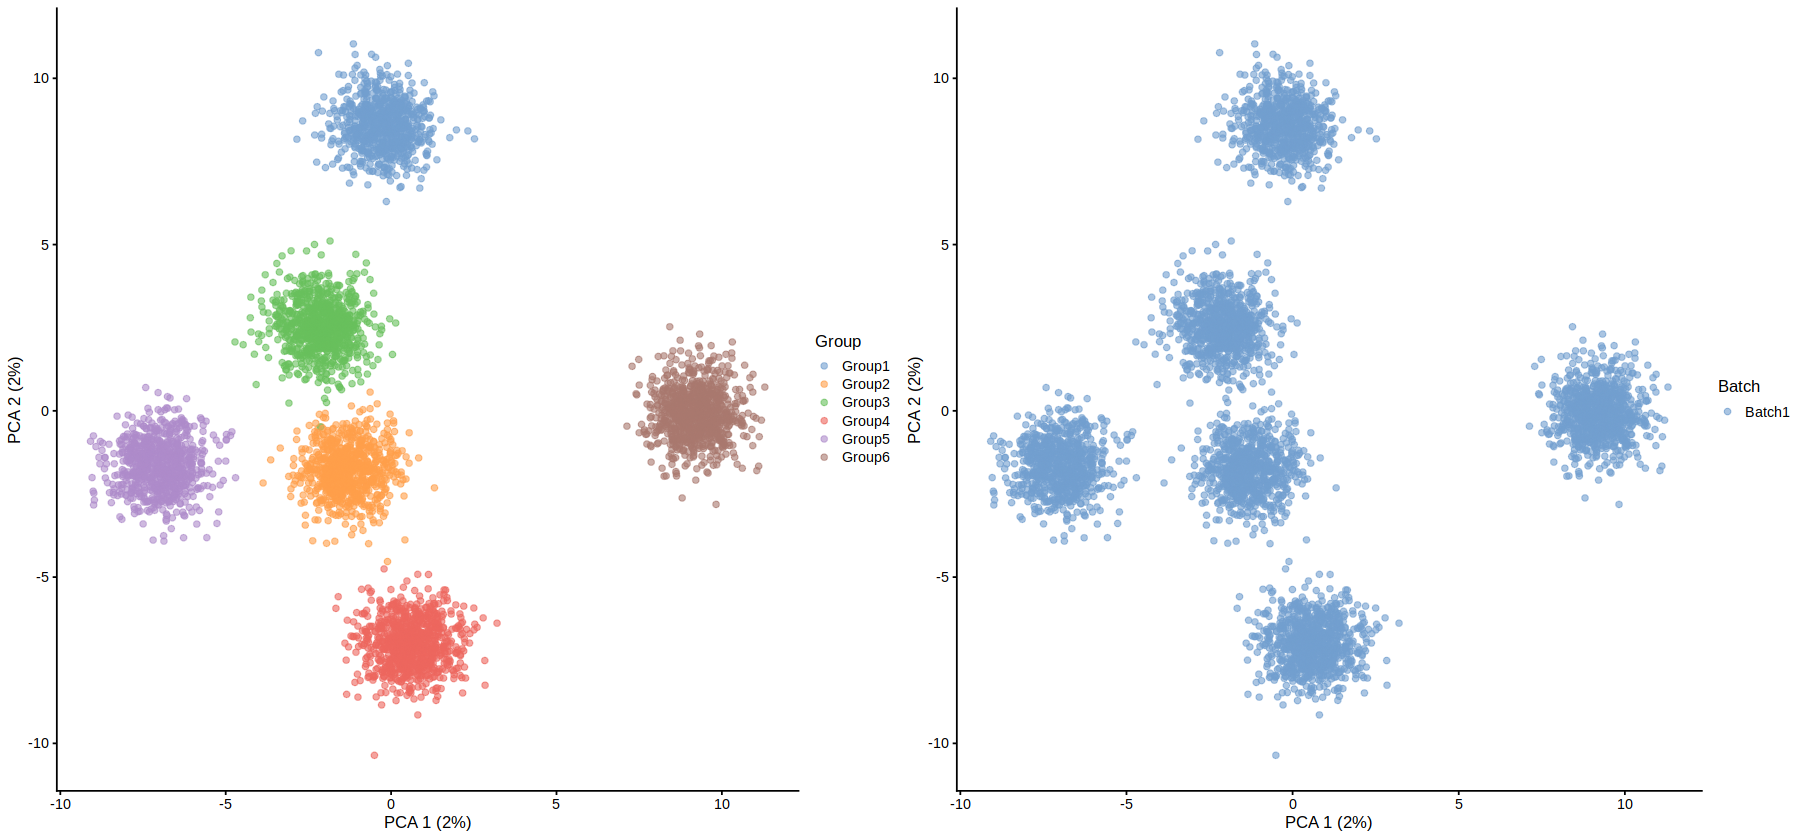

In [5]:
sim.baseline.viz<-sim.baseline

sim.baseline.viz <- qc.data(sim.baseline.viz)
sim.baseline.viz <- scater::logNormCounts(sim.baseline.viz)
sim.baseline.viz <- scran::fixedPCA(sim.baseline.viz, assay.type = 'logcounts', subset.row=NULL) # default 50 PCs

h_ = 7
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

g1a<-plotPCA(sim.baseline.viz, colour_by = "Group")
g1b<-plotPCA(sim.baseline.viz, colour_by = "Batch")

g1<-ggpubr::ggarrange(g1a, g1b, ncol = 2)
# for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data.path, 'figures/', 'batch_effect_baseline', ext), g1, 
#                                              height = h_, width = w_)}
g1

Next, we add some context-specific noise to create a tensor that will have multiple factors. 

This context-specific noise will be added to each simulation (need to double check that the cell groups are consistently split the same for this).

In [5]:
set.seed(seed)
contexts <- BBmisc::chunk(colnames(sim.baseline),
                                    chunk.size = n.cells/n.contexts,
                                    shuffle = TRUE)

context.noise<-list()
for (i in seq_along(contexts)){
    context.cells<-contexts[[i]]
    
    noise.sim <- splatSimulate(
                nGenes = n.genes,
                batchCells = length(context.cells),
                lib.loc    = 6,
                lib.scale  = 0.6,
                verbose    = FALSE,
                seed       = seed+i
            )
    context.noise[[i]]<-noise.sim
}
sim.baseline.context<-add.context.noise(sim.baseline, context.noise, contexts)

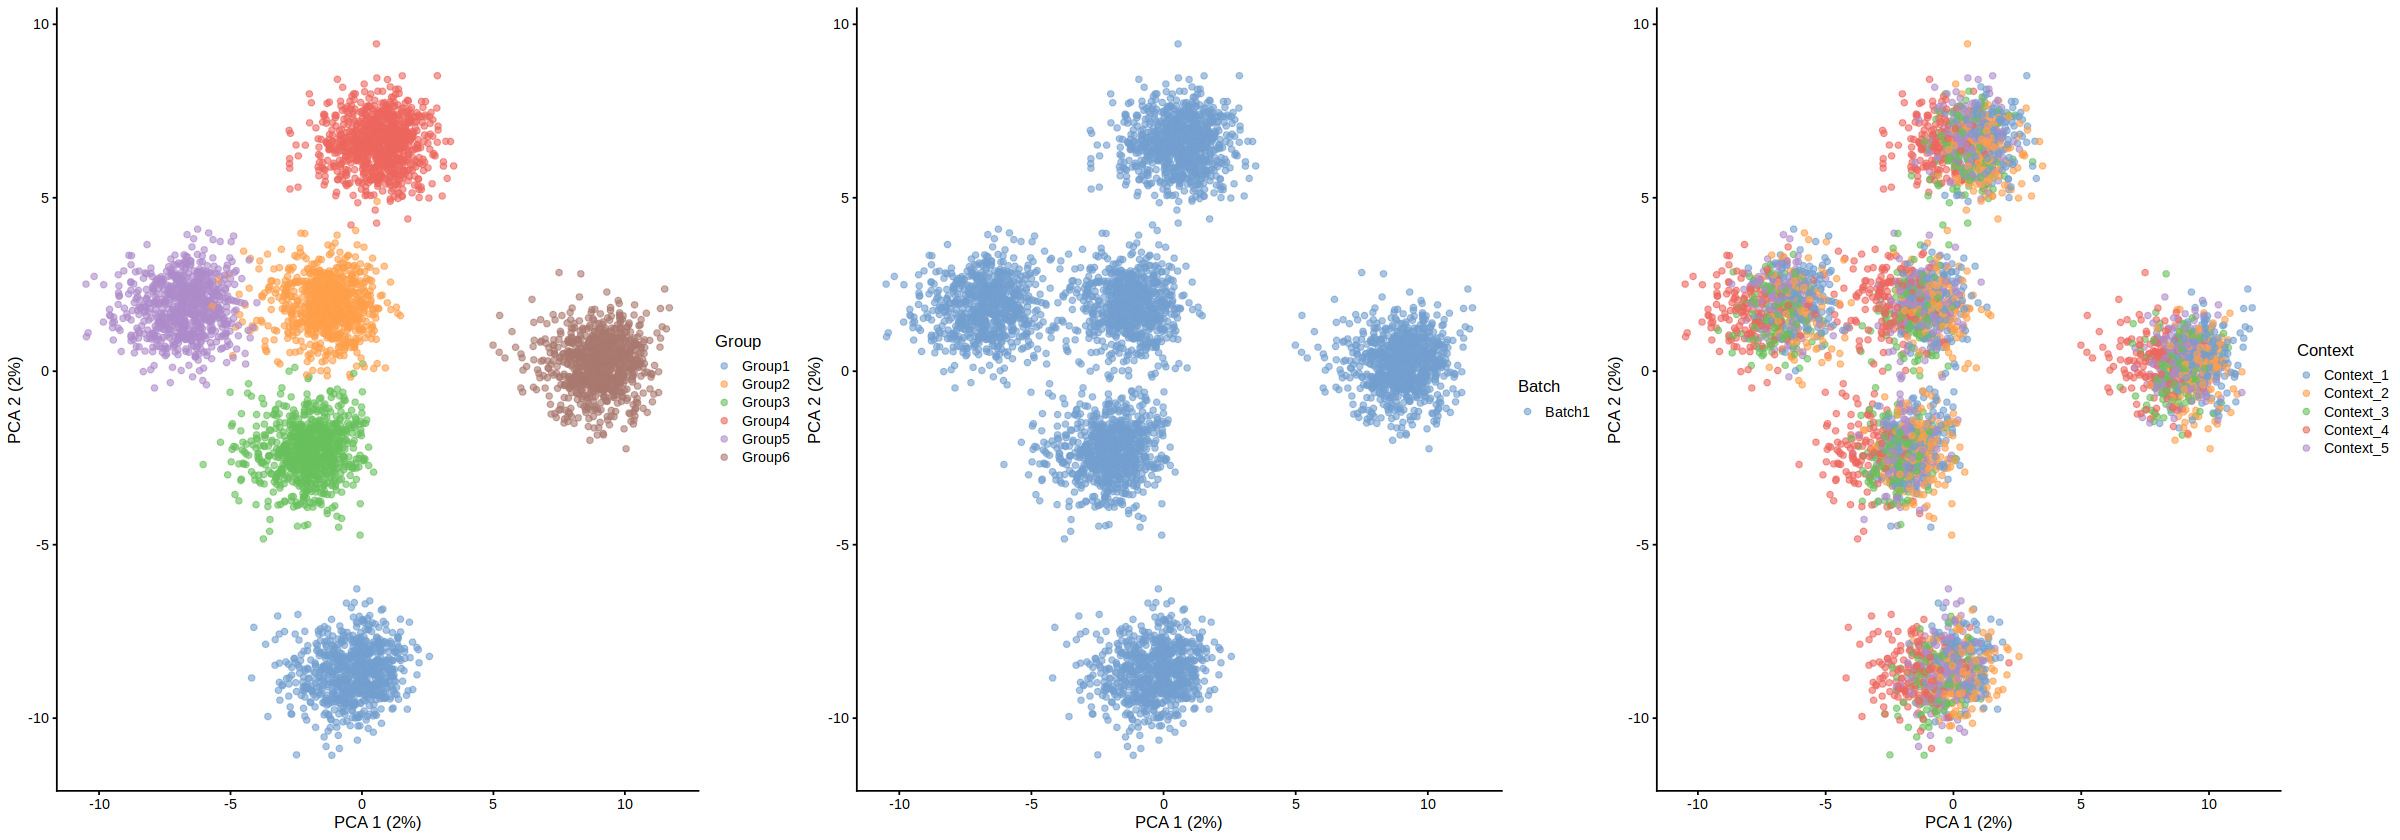

In [7]:
sim.viz<-sim.baseline.context
sim.viz<-qc.data(sim.viz)
sim.viz <- scater::logNormCounts(sim.viz)
sim.viz <- scran::fixedPCA(sim.viz, assay.type = 'logcounts', subset.row=NULL) # default 50 PCs

h_ = 7
w_ = 20
options(repr.plot.height=h_, repr.plot.width=w_)

g2a<-plotPCA(sim.viz, colour_by = "Group")
g2b<-plotPCA(sim.viz, colour_by = "Batch")
g2c<-plotPCA(sim.viz, colour_by = "Context")


g2<-ggpubr::ggarrange(g2a, g2b, g2c, ncol = 3)
# for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data.path, 'figures/', 'batch_effect_baseline_context', ext), g2, 
#                                              height = h_, width = w_)}
g2

In [7]:
df<-data.frame(colData(sim.baseline.context))
cell.counts<-ddply(df, .(df$Context, df$Group), nrow)
reshape2::dcast(df, Context ~ Group)

Using Context as value column: use value.var to override.

Aggregation function missing: defaulting to length



Context   Group1 Group2 Group3 Group4 Group5 Group6
1 Context_1 153    152    171    174    169    181   
2 Context_2 157    161    184    181    136    181   
3 Context_3 147    151    195    166    165    176   
4 Context_4 180    170    143    181    165    161   
5 Context_5 166    161    160    191    148    174

## LR simulation

In [6]:
# generate a LR PPI on a subset of the genes
set.seed(seed)
lr.genes<-sort(as.character(sample(rownames(sim.baseline.context), size = n.lrs, replace = FALSE)))
lr.ppi<-generate.lr.ppi(lr.genes)
interacting.lr.genes<-unique(c(lr.ppi$source_genesymbol, lr.ppi$target_genesymbol))

## Expected Tensor Rank

In [10]:
sim.baseline.context.list<-split.by.context(sim.baseline.context, context_lab = 'Context') 

# log-normalize
sim.baseline.context.list<-lapply(sim.baseline.context.list, FUN = function(sce) {
    sce <- scater::logNormCounts(sce)
})

# calculate communication scores
scores.baseline.context<-score.communication(sim.baseline.context.list, lr.ppi)

In [17]:
sim.baseline.context.list<-split.by.context(sim.baseline.context, context_lab = 'Context') 

# log-normalize
sim.baseline.context.list<-lapply(sim.baseline.context.list, FUN = function(sce) {
    sce <- scater::logNormCounts(sce)
})

# calculate communication scores
scores.baseline.context<-score.communication(sim.baseline.context.list, lr.ppi)

# build and decompose tensor
tensor.baseline.context<-list()
for (score.type in names(scores.baseline.context)){
    if (gpu){
        tensor.baseline.context[[score.type]]<-liana_tensor_c2c_gpu(context_df_dict = scores.baseline.context[[score.type]], 
                                                                   runs = 3)
    }else{
        tensor.baseline.context[[score.type]]<-liana_tensor_c2c(context_df_dict = scores.baseline.context[[score.type]],
                                           score_col = 'score',
                                           ligand_col = 'ligand', 
                                           receptor_col = 'receptor', 
                                           lr_fill = NaN, 
                                           cell_fill = NaN,
                                           how = 'outer',
                                           seed = 888, 
                                           conda_env = env.name,
                                           build_only = F)        
    }
}

for (score.type in names(tensor.baseline.context)){
    print(paste0('The rank with context-effects using ', score.type, ' is ', tensor.baseline.context[[score.type]]$rank))
}

Loading `ccc_protocols` Conda Environment

Building the tensor...

Loading `ccc_protocols` Conda Environment

Building the tensor...



[1] "The rank with context-effects using natmi is 7"
[1] "The rank with context-effects using sca is 7"


### Visualize decomposition

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 5 rows [1, 2, 3, 4, 5].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 5 rows [1, 2, 3, 4, 5].”


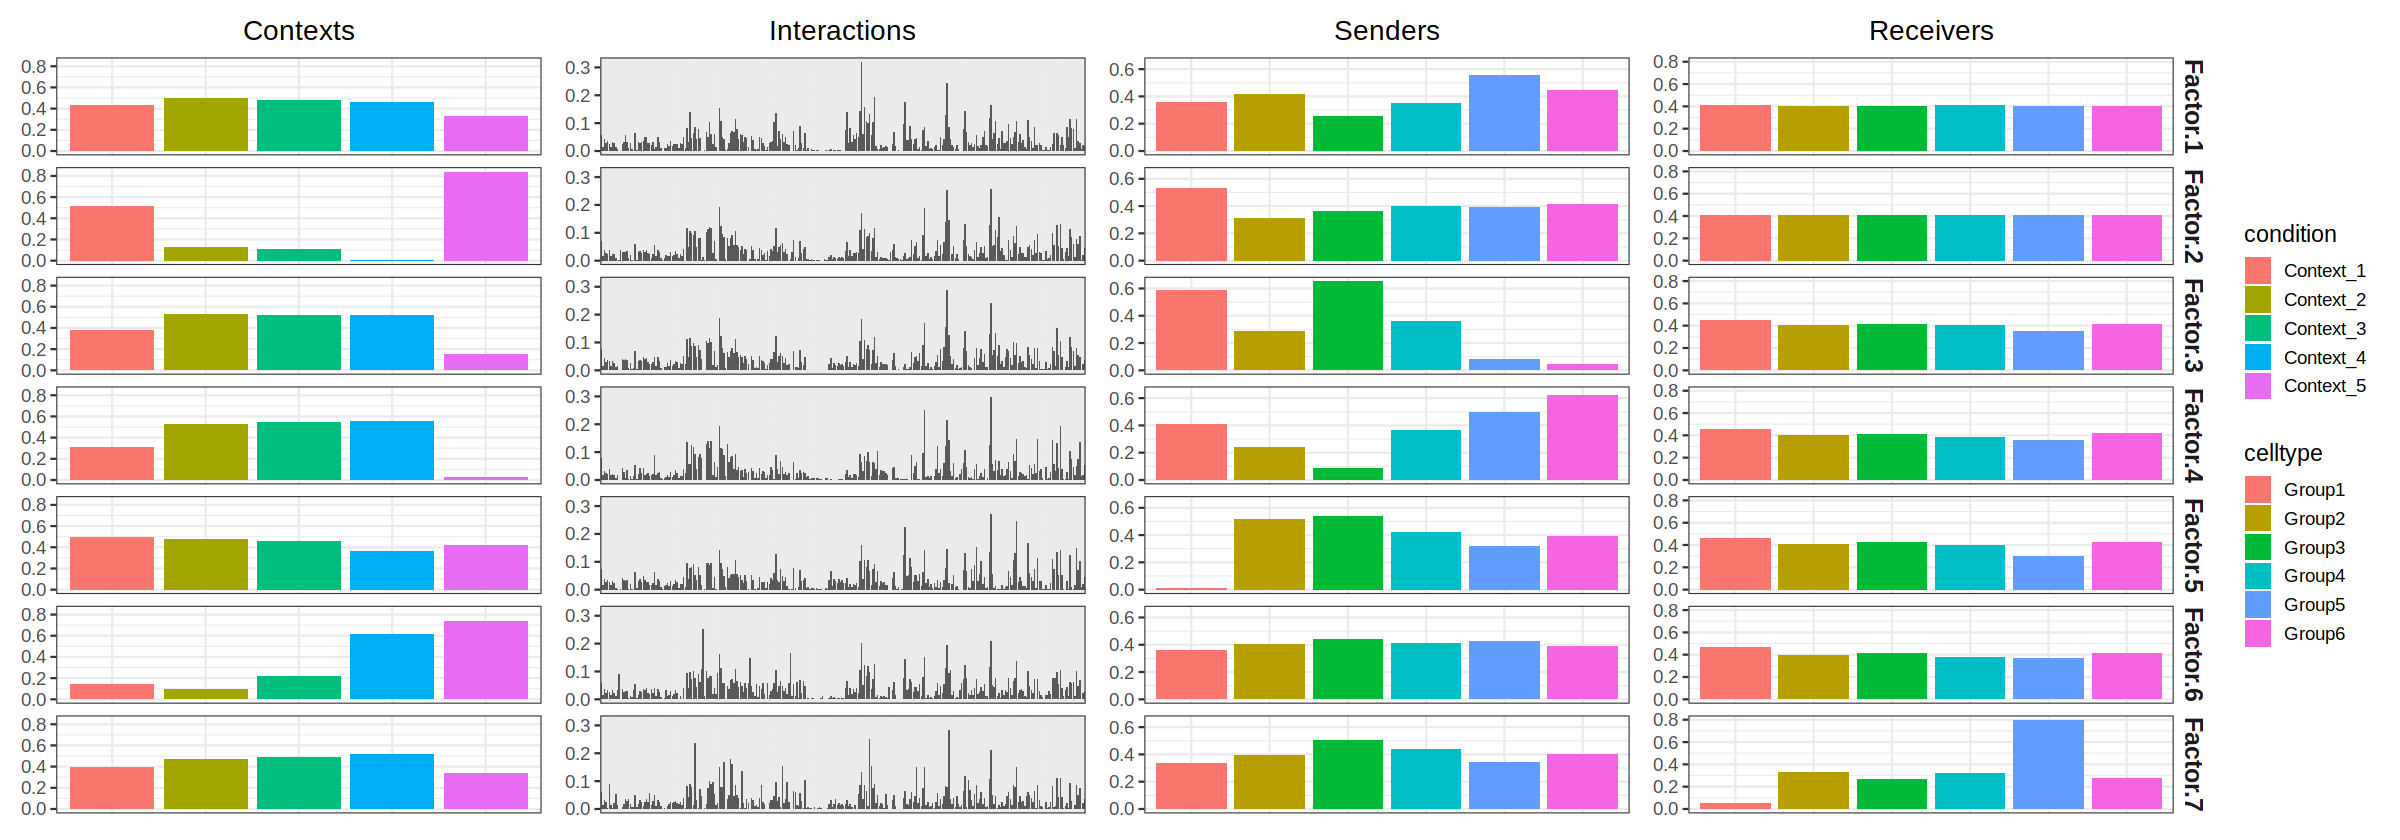

In [18]:
suppressMessages({
    natmi.factors <- format_c2c_factors(tensor.baseline.context$natmi$factors)
    sca.factors <- format_c2c_factors(tensor.baseline.context$sca$factors)
})

plot_c2c_overview(natmi.factors)

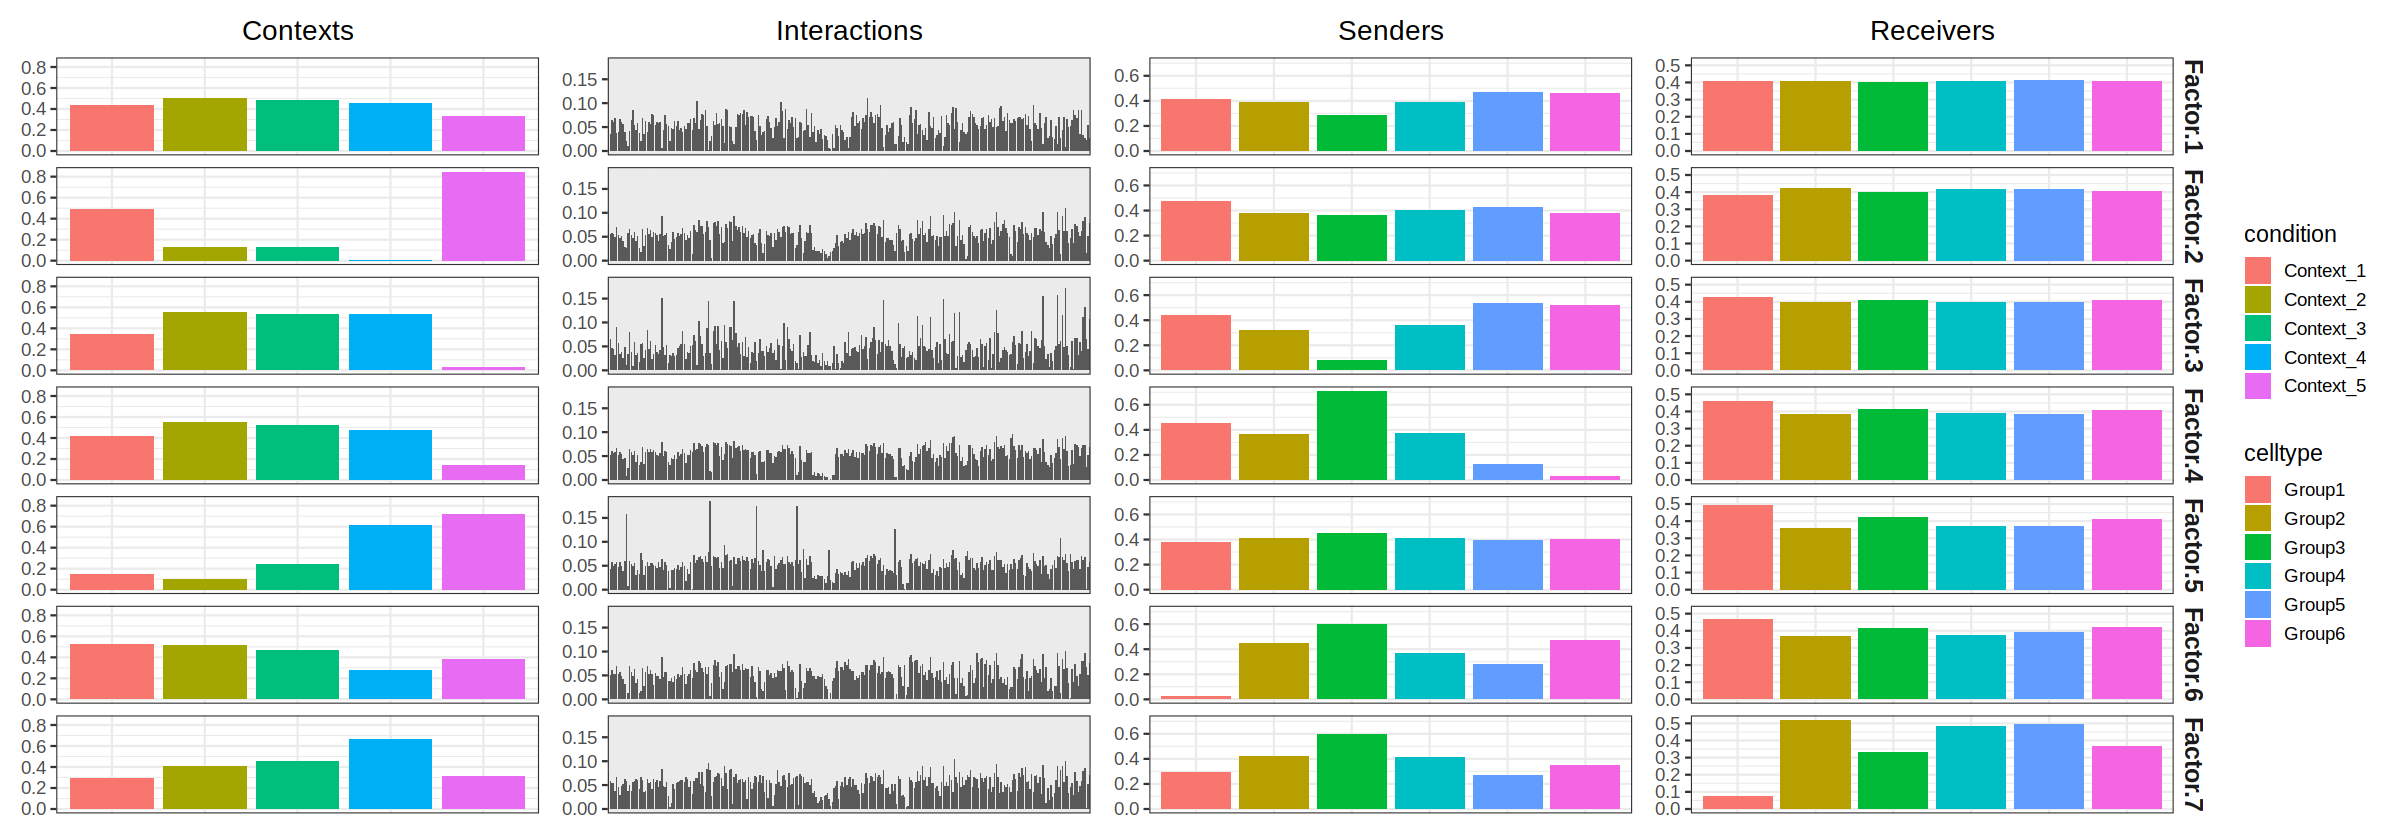

In [19]:
plot_c2c_overview(sca.factors)

# Example of an iteration

Here is what the baseline params with an actual batch effect simulation looks like:

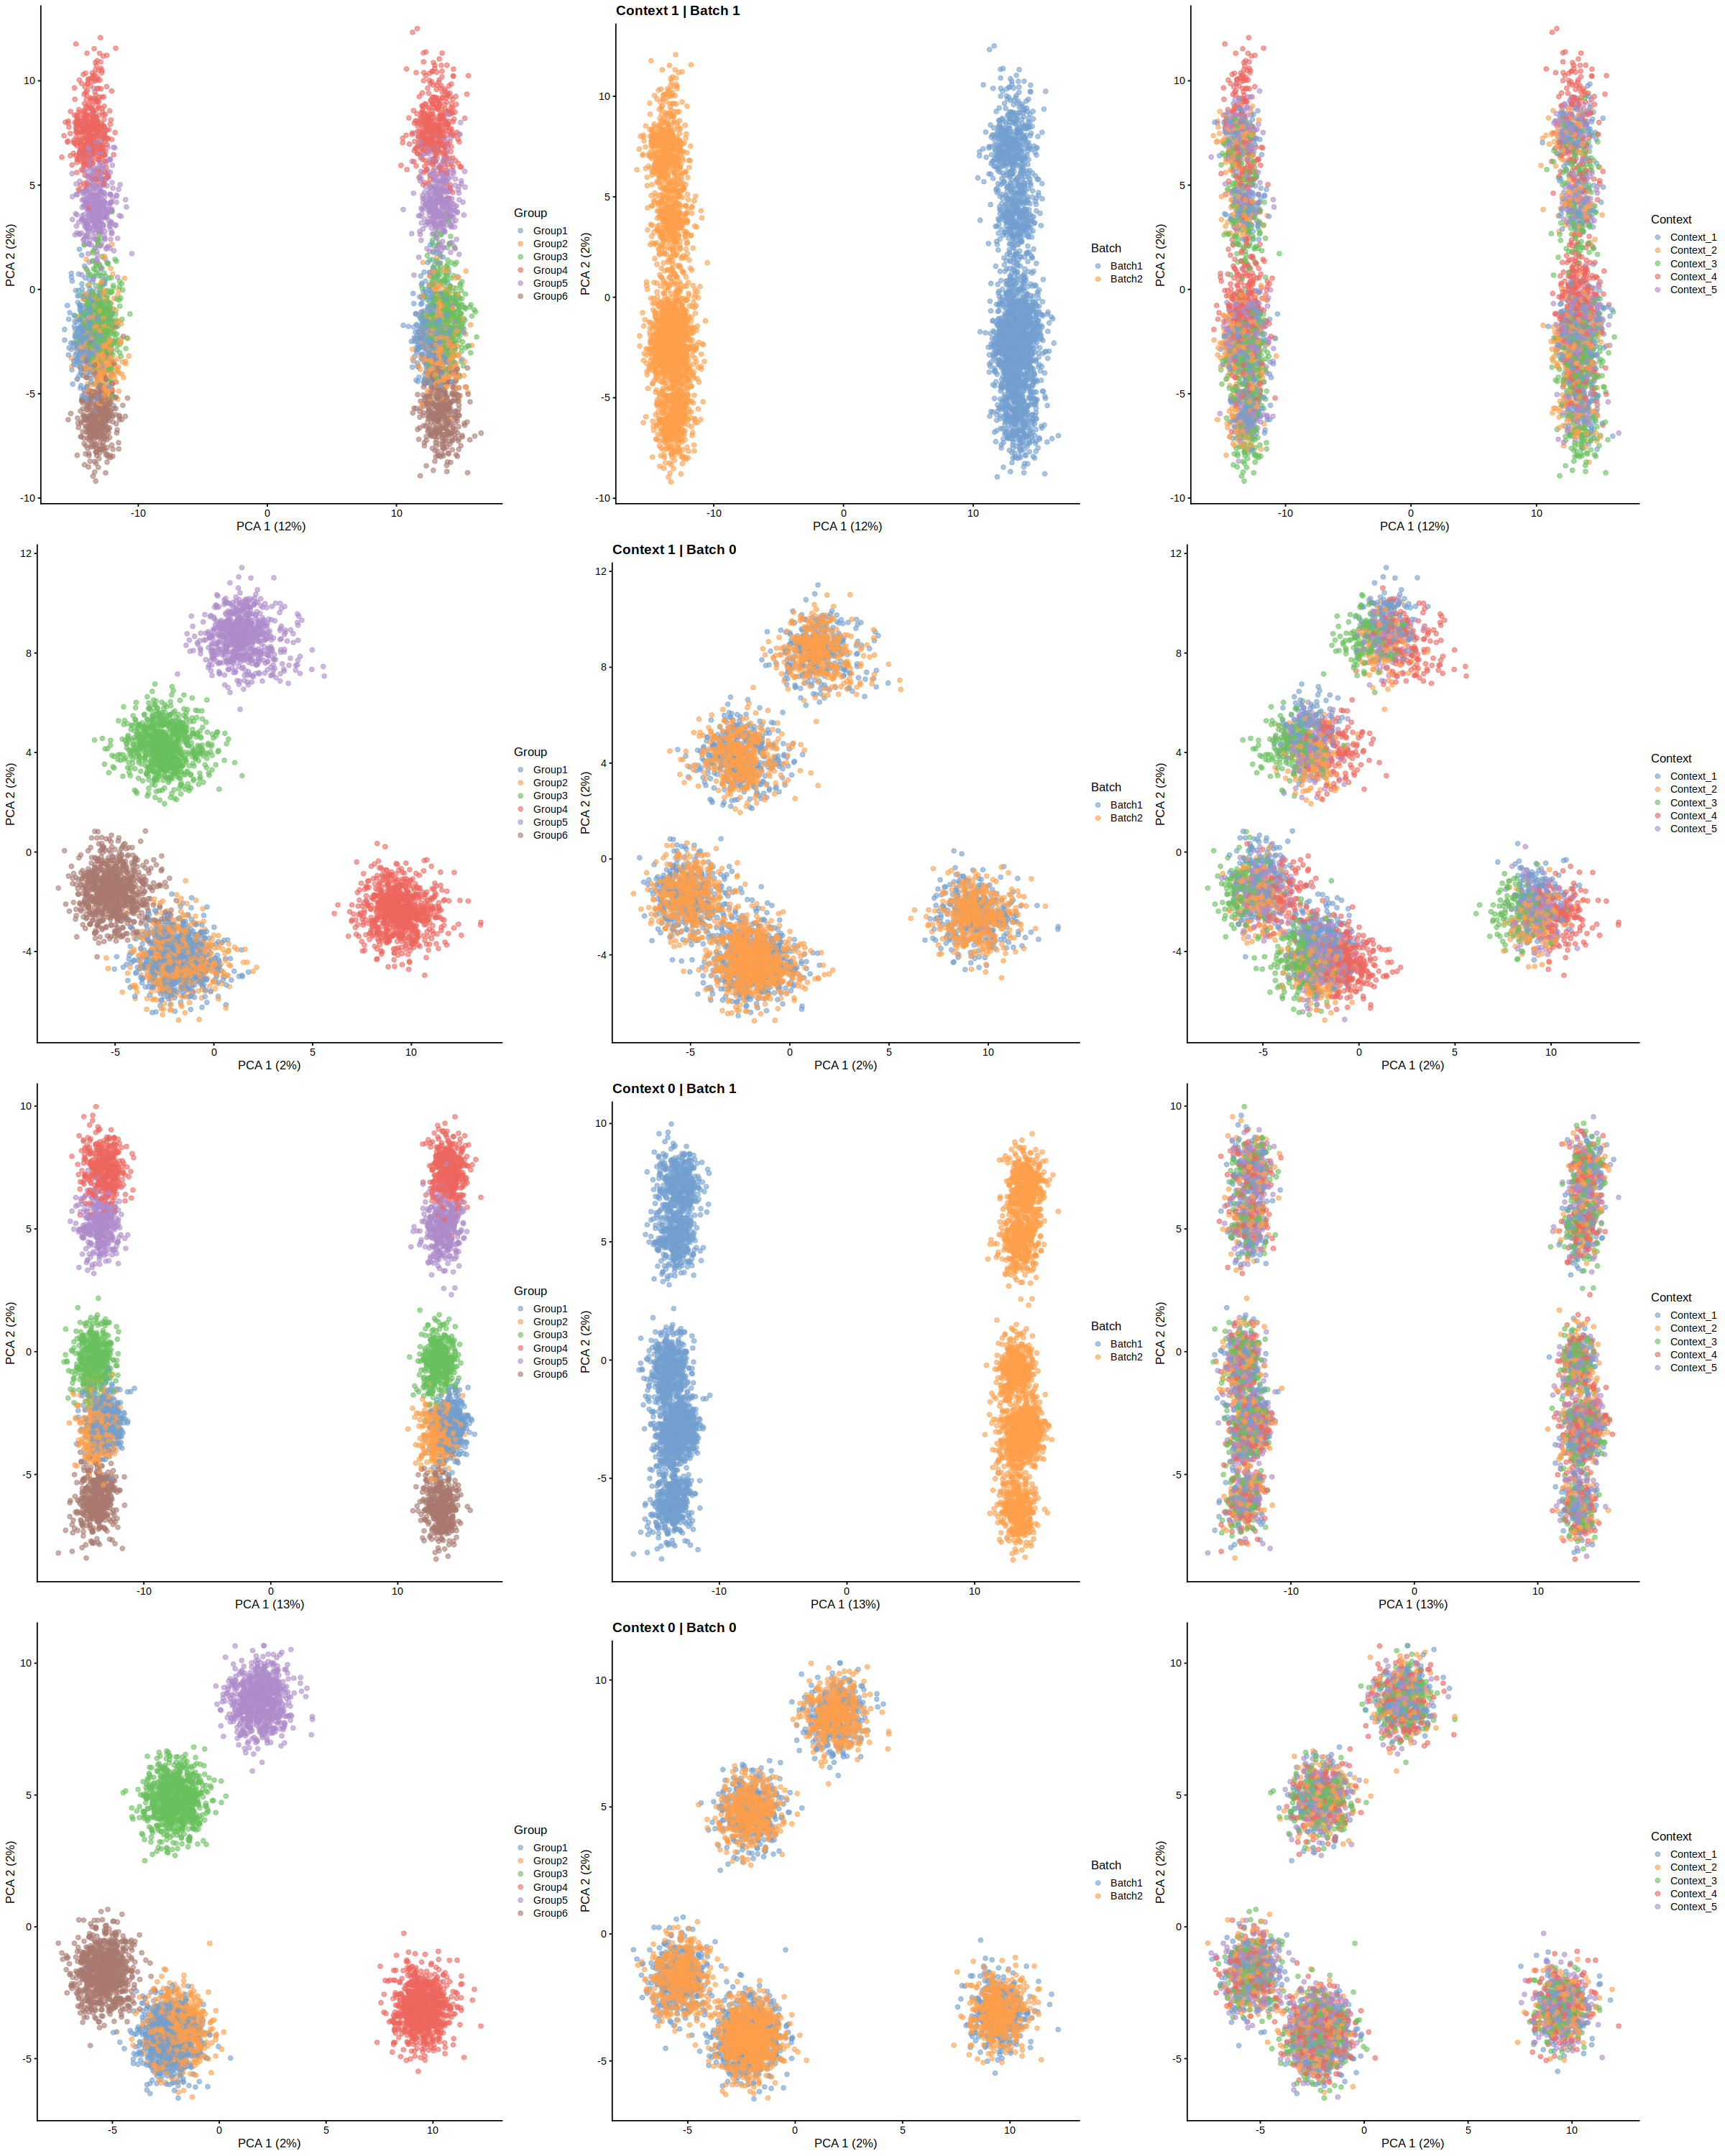

In [16]:
iter.params.list = list()
iter.params.list[[1]] = list(n.batches = 2, batch.scale = 0.25, batch.location = 0.25)
iter.params<-iter.params.list[[1]]

sim_params <- setParams(
    baseline_params,
    
    # batches
    batchCells = rep(n.cells/iter.params$n.batches, iter.params$n.batches),
    batch.facLoc = iter.params$batch.location, # higher values increase batch severity
    batch.facScale = iter.params$batch.scale, # higher values increase batch severity
    batch.rmEffect = FALSE, # create the gold standard when set to True

)

sim<-splatSimulateGroups(sim_params, verbose = F)
sim.gold<-splatSimulateGroups(sim_params, verbose = F, batch.rmEffect = T)
sim.gold<-splatSimulateGroups(sim_params, verbose = F, batch.rmEffect = T)
expr.datasets<-list(sim.gold = sim.gold, sim.log = sim)

expr.datasets.nc<-expr.datasets
expr.datasets<-lapply(expr.datasets, FUN = function(sce) add.context.noise(sce, context.noise, contexts))
                      
expr.datasets<-lapply(expr.datasets, FUN = function(sce) qc.data(sce))
expr.datasets.nc<-lapply(expr.datasets.nc, FUN = function(sce) qc.data(sce))
                         
expr.datasets<-lapply(expr.datasets, FUN = function(sce) scater::logNormCounts(sce))
expr.datasets.nc<-lapply(expr.datasets.nc, FUN = function(sce) scater::logNormCounts(sce))
                         
expr.datasets<-lapply(expr.datasets, FUN = function(sce) scran::fixedPCA(sce, assay.type = 'logcounts', subset.row=NULL))
expr.datasets.nc<-lapply(expr.datasets.nc, FUN = function(sce) scran::fixedPCA(sce, assay.type = 'logcounts', subset.row=NULL))

                         
intersect.cells<-Reduce(intersect, list(colnames(expr.datasets$sim.log), colnames(expr.datasets$sim.gold), 
                       colnames(expr.datasets.nc$sim.log), colnames(expr.datasets.nc$sim.gold)))
expr.datasets<-lapply(expr.datasets, FUN = function(sce) sce[, intersect.cells])
expr.datasets.nc<-lapply(expr.datasets.nc, FUN = function(sce) sce[, intersect.cells])
                         
for (i in seq_along(expr.datasets.nc)){
    sce<-expr.datasets.nc[[i]]
    colData(sce)[['Context']] = colData(expr.datasets$sim.log)$Context
    expr.datasets.nc[[i]]<-sce
}

h_ = 25
w_ = 20
options(repr.plot.height=h_, repr.plot.width=w_)

g1a<-plotPCA(expr.datasets$sim.log, colour_by = "Group")
g1b<-plotPCA(expr.datasets$sim.log, colour_by = "Batch") + ggtitle('Context 1 | Batch 1')
g1c<-plotPCA(expr.datasets$sim.log, colour_by = "Context")
g1<-ggpubr::ggarrange(g1a, g1b, g1c, ncol = 3)

g2a<-plotPCA(expr.datasets$sim.gold, colour_by = "Group")
g2b<-plotPCA(expr.datasets$sim.gold, colour_by = "Batch") + ggtitle('Context 1 | Batch 0')
g2c<-plotPCA(expr.datasets$sim.gold, colour_by = "Context")
g2<-ggpubr::ggarrange(g2a, g2b, g2c, ncol = 3) 

g3a<-plotPCA(expr.datasets.nc$sim.log, colour_by = "Group")
g3b<-plotPCA(expr.datasets.nc$sim.log, colour_by = "Batch") + ggtitle('Context 0 | Batch 1')
g3c<-plotPCA(expr.datasets.nc$sim.log, colour_by = "Context")
g3<-ggpubr::ggarrange(g3a, g3b, g3c, ncol = 3)

g4a<-plotPCA(expr.datasets.nc$sim.gold, colour_by = "Group")
g4b<-plotPCA(expr.datasets.nc$sim.gold, colour_by = "Batch") + ggtitle('Context 0 | Batch 0')
g4c<-plotPCA(expr.datasets.nc$sim.gold, colour_by = "Context")
g4<-ggpubr::ggarrange(g4a, g4b, g4c, ncol = 3) 

g4<-ggpubr::ggarrange(g1,g2,g3,g4, ncol = 1) 
g4

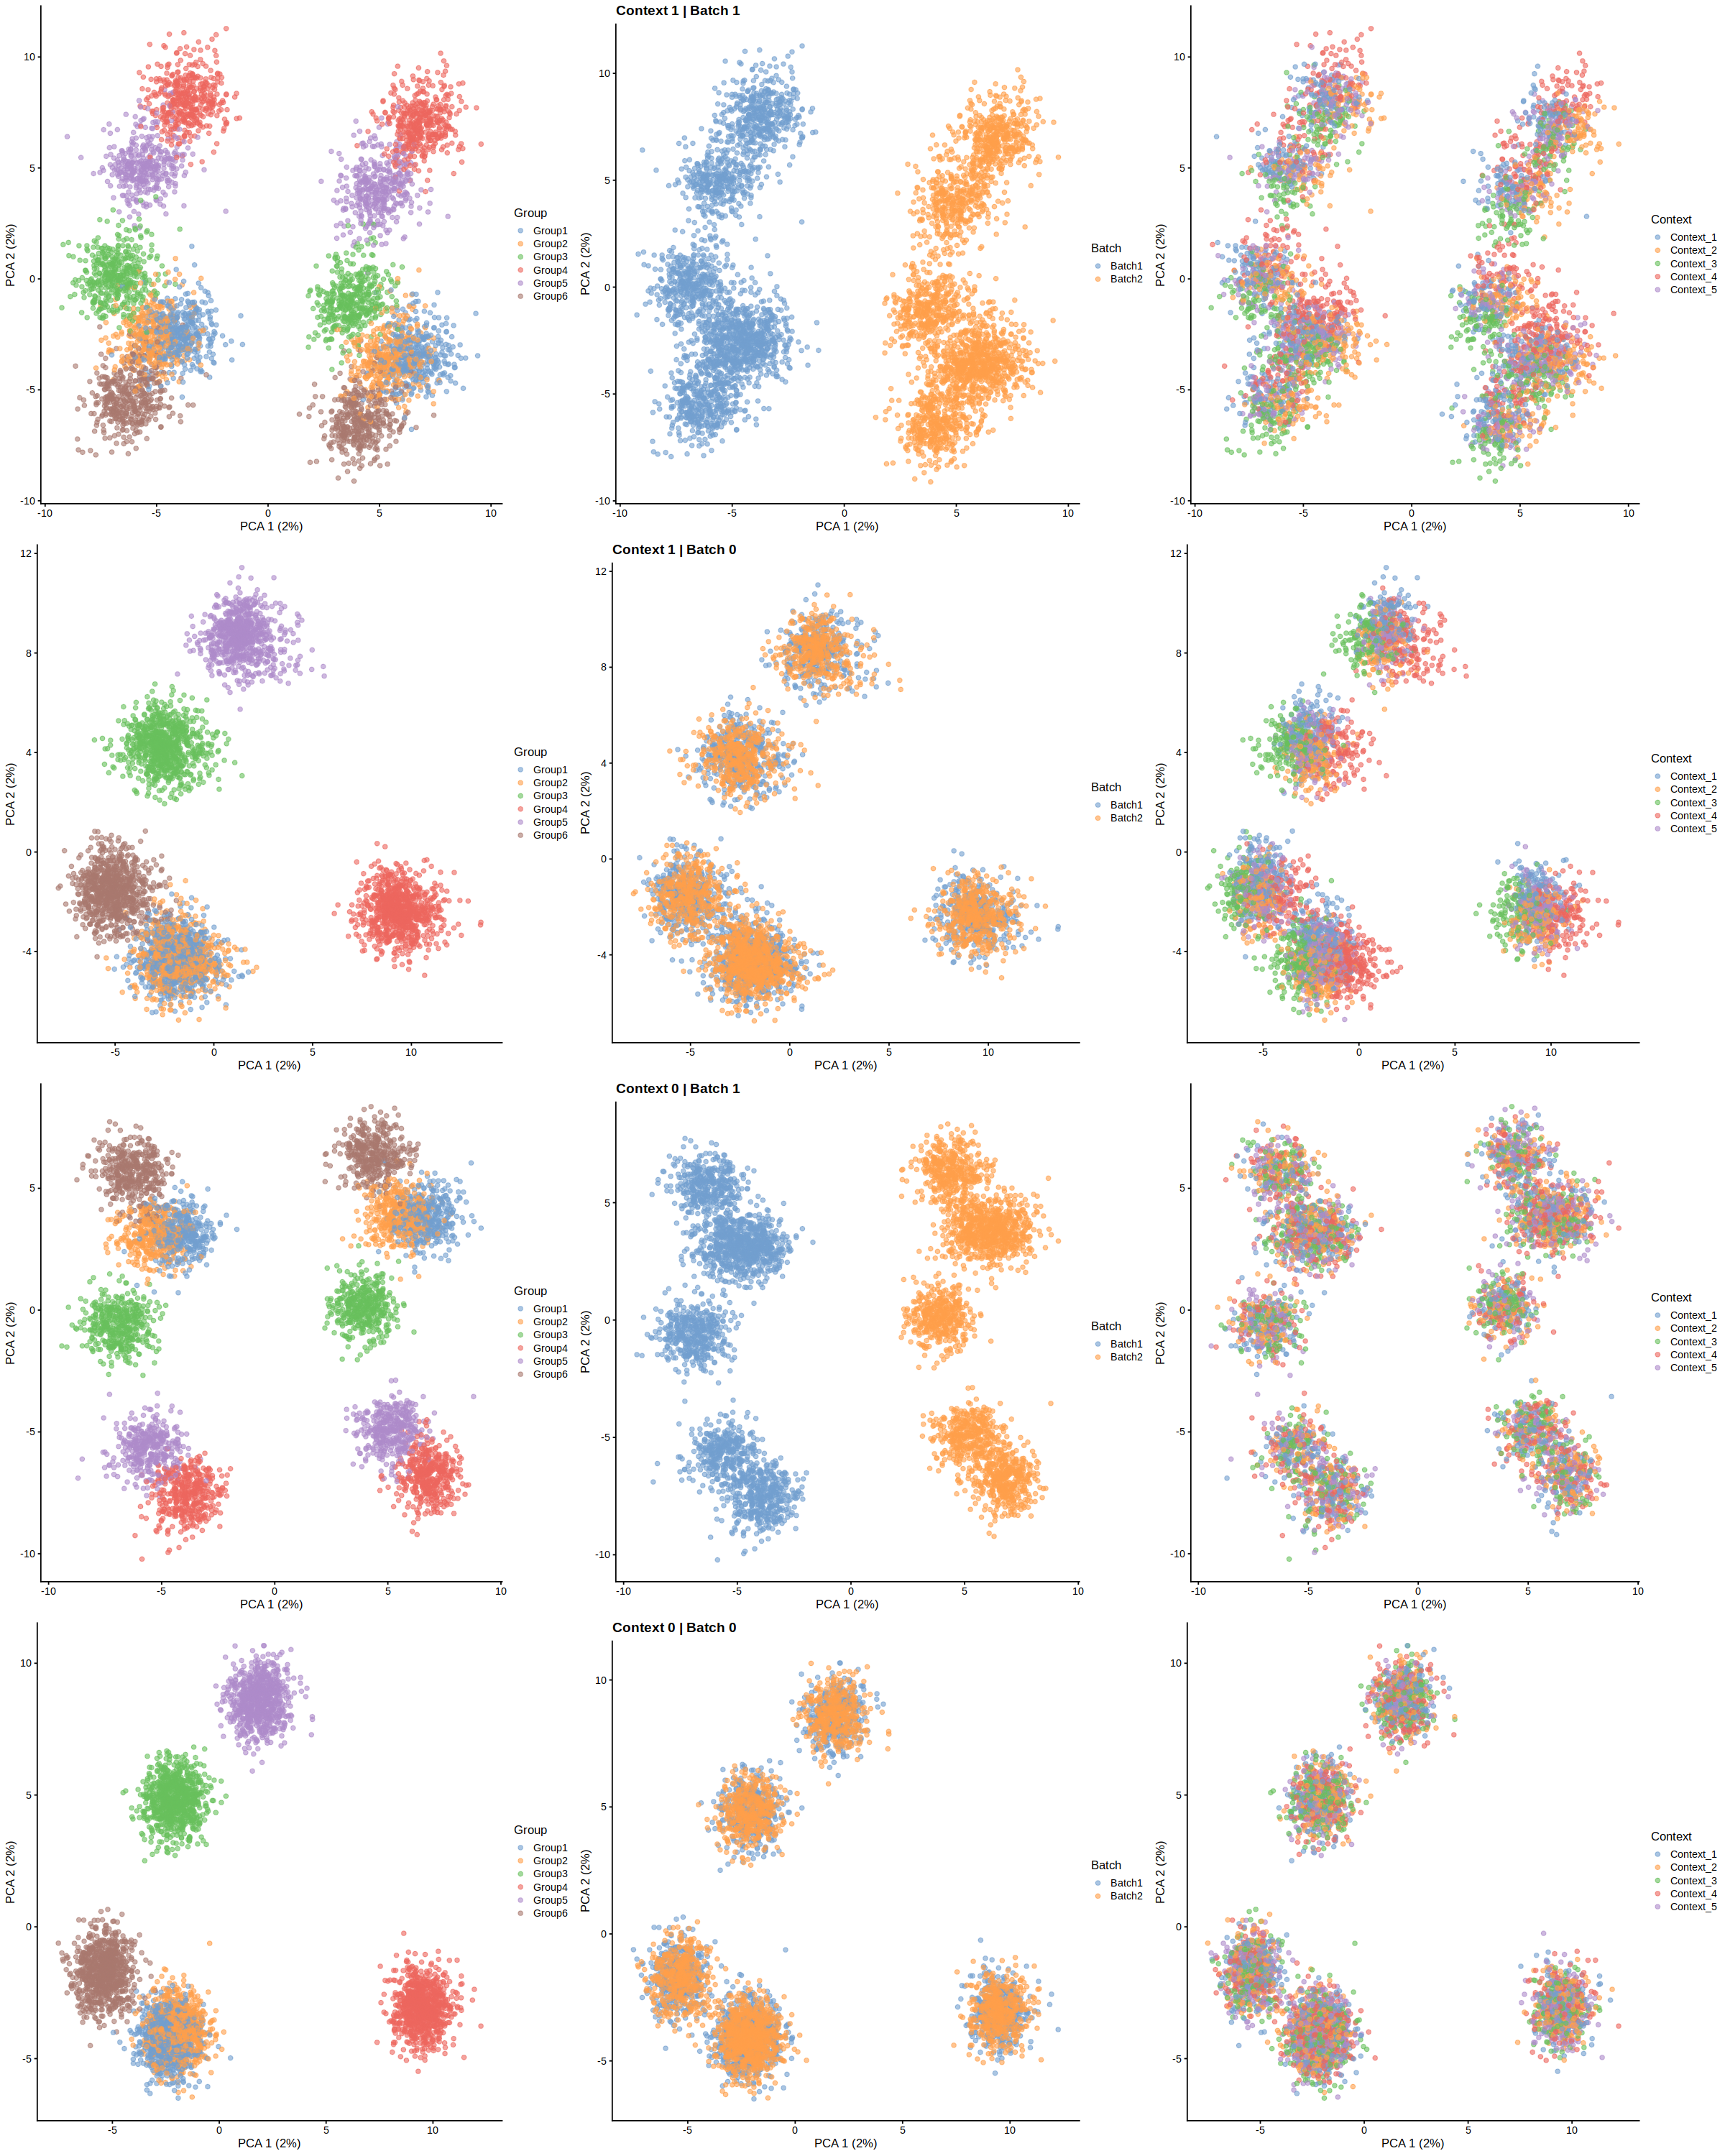

In [17]:
iter.params.list = list()
iter.params.list[[1]] = list(n.batches = 2, batch.scale = 0.1, batch.location = 0.1)
iter.params<-iter.params.list[[1]]

sim_params <- setParams(
    baseline_params,
    
    # batches
    batchCells = rep(n.cells/iter.params$n.batches, iter.params$n.batches),
    batch.facLoc = iter.params$batch.location, # higher values increase batch severity
    batch.facScale = iter.params$batch.scale, # higher values increase batch severity
    batch.rmEffect = FALSE, # create the gold standard when set to True

)

sim<-splatSimulateGroups(sim_params, verbose = F)
sim.gold<-splatSimulateGroups(sim_params, verbose = F, batch.rmEffect = T)
sim.gold<-splatSimulateGroups(sim_params, verbose = F, batch.rmEffect = T)
expr.datasets<-list(sim.gold = sim.gold, sim.log = sim)

expr.datasets.nc<-expr.datasets
expr.datasets<-lapply(expr.datasets, FUN = function(sce) add.context.noise(sce, context.noise, contexts))
                      
expr.datasets<-lapply(expr.datasets, FUN = function(sce) qc.data(sce))
expr.datasets.nc<-lapply(expr.datasets.nc, FUN = function(sce) qc.data(sce))
                         
expr.datasets<-lapply(expr.datasets, FUN = function(sce) scater::logNormCounts(sce))
expr.datasets.nc<-lapply(expr.datasets.nc, FUN = function(sce) scater::logNormCounts(sce))
                         
expr.datasets<-lapply(expr.datasets, FUN = function(sce) scran::fixedPCA(sce, assay.type = 'logcounts', subset.row=NULL))
expr.datasets.nc<-lapply(expr.datasets.nc, FUN = function(sce) scran::fixedPCA(sce, assay.type = 'logcounts', subset.row=NULL))

                         
intersect.cells<-Reduce(intersect, list(colnames(expr.datasets$sim.log), colnames(expr.datasets$sim.gold), 
                       colnames(expr.datasets.nc$sim.log), colnames(expr.datasets.nc$sim.gold)))
expr.datasets<-lapply(expr.datasets, FUN = function(sce) sce[, intersect.cells])
expr.datasets.nc<-lapply(expr.datasets.nc, FUN = function(sce) sce[, intersect.cells])
                         
for (i in seq_along(expr.datasets.nc)){
    sce<-expr.datasets.nc[[i]]
    colData(sce)[['Context']] = colData(expr.datasets$sim.log)$Context
    expr.datasets.nc[[i]]<-sce
}

h_ = 25
w_ = 20
options(repr.plot.height=h_, repr.plot.width=w_)

g1a<-plotPCA(expr.datasets$sim.log, colour_by = "Group")
g1b<-plotPCA(expr.datasets$sim.log, colour_by = "Batch") + ggtitle('Context 1 | Batch 1')
g1c<-plotPCA(expr.datasets$sim.log, colour_by = "Context")
g1<-ggpubr::ggarrange(g1a, g1b, g1c, ncol = 3)

g2a<-plotPCA(expr.datasets$sim.gold, colour_by = "Group")
g2b<-plotPCA(expr.datasets$sim.gold, colour_by = "Batch") + ggtitle('Context 1 | Batch 0')
g2c<-plotPCA(expr.datasets$sim.gold, colour_by = "Context")
g2<-ggpubr::ggarrange(g2a, g2b, g2c, ncol = 3) 

g3a<-plotPCA(expr.datasets.nc$sim.log, colour_by = "Group")
g3b<-plotPCA(expr.datasets.nc$sim.log, colour_by = "Batch") + ggtitle('Context 0 | Batch 1')
g3c<-plotPCA(expr.datasets.nc$sim.log, colour_by = "Context")
g3<-ggpubr::ggarrange(g3a, g3b, g3c, ncol = 3)

g4a<-plotPCA(expr.datasets.nc$sim.gold, colour_by = "Group")
g4b<-plotPCA(expr.datasets.nc$sim.gold, colour_by = "Batch") + ggtitle('Context 0 | Batch 0')
g4c<-plotPCA(expr.datasets.nc$sim.gold, colour_by = "Context")
g4<-ggpubr::ggarrange(g4a, g4b, g4c, ncol = 3) 

g4<-ggpubr::ggarrange(g1,g2,g3,g4, ncol = 1) 
g4

# Iterate Batch Effects

In [7]:
n.batches<-c(2, 4, 5) # 8
batch.locations<-c(0.01, 0.05, seq(0.1, 0.5, 0.1))
batch.scales<-c(0.01, 0.05, seq(0.1, 0.5, 0.1))

iter.params.list<-list()
counter<-1
for (nb in n.batches){
    for (bs in batch.scales){
        for (bl in batch.locations){
            iter.params.list[[counter]]<-list(n.batches = nb, 
                                             batch.scale = bs, 
                                             batch.location = bl)
            counter<-counter + 1
        }
    }
}

print(paste0('The number of iterations is: ', length(iter.params.list)))

[1] "The number of iterations is: 147"


In [8]:
count.types.names<-c('gold', 'log', 'scanorama', 'scvi')
res.col.names<-c('iteration', 'n.batches', 'batch.scale', 'batch.location', 
                 sapply(unlist(lapply(count.types.names, function(a) lapply(c('clusterability.kmeans', 'clusterability.louvain', 'mixability'), function (b) c(a, b))), recursive=FALSE), 
                    function(x) paste0(x, collapse = '_')), 
                  sapply(unlist(lapply(c('natmi', 'sca'), 
              function(a) lapply(count.types.names[2:4], function (b) c(a, b))), recursive=FALSE), 
        function(x) paste0('frac_0_', 'corr.index_', x[[2]], '_', x[[1]])),
                sapply(unlist(lapply(c('natmi', 'sca'), 
              function(a) lapply(count.types.names[2:4], function (b) c(a, b))), recursive=FALSE), 
        function(x) paste0('frac_0.1_', 'corr.index_', x[[2]], '_', x[[1]])),
                sapply(unlist(lapply(c('frac_0', 'frac_0.1'), function(a) lapply(c('natmi', 'sca'), function (b) c(a, b))), recursive=FALSE), 
                    function(x) paste0(c('n.tensor.elements', x), collapse = '_')), 
              c('scanorama_frac.negative', 'scvi_frac.negative'),
        sapply(unlist(lapply(c('frac_0', 'frac_0.1'), function(a) lapply(c('natmi', 'sca'), function (b) c(a, b))), recursive=FALSE), 
                    function(x) paste0(c('rank', x), collapse = '_'))
               )                                                            

res.df <- data.frame(matrix(ncol = length(res.col.names), nrow = 0))
colnames(res.df)<-res.col.names

iter<-1

# Begin test

In [115]:
iter<-49
iter.params<-iter.params.list[[iter]]

In [116]:
print(iter)
sim_params <- setParams(
    baseline_params,

    # batches
    batchCells = rep(n.cells/iter.params$n.batches, iter.params$n.batches),
    batch.facLoc = iter.params$batch.location, # higher values increase batch severity
    batch.facScale = iter.params$batch.scale, # higher values increase batch severity
    batch.rmEffect = FALSE, # create the gold standard when set to True

)

print('process')
sim<-splatSimulateGroups(sim_params, verbose = F)
sim.gold<-splatSimulateGroups(sim_params, verbose = F, batch.rmEffect = T)
expr.datasets<-list(sim.gold = sim.gold, sim.log = sim)

expr.datasets<-lapply(expr.datasets, FUN = function(sce) add.context.noise(sce, context.noise, contexts))                      
expr.datasets<-lapply(expr.datasets, FUN = function(sce) qc.data(sce))

genes.intersect<-intersect(rownames(expr.datasets$sim.log), rownames(expr.datasets$sim.gold))
cells.intersect<-intersect(colnames(expr.datasets$sim.log), colnames(expr.datasets$sim.gold))
expr.datasets<-lapply(expr.datasets, FUN = function(sce) {
    sce <- sce[genes.intersect, cells.intersect] # retain only genes/cells in common b/w the 2 datasets
    sce <- scater::logNormCounts(sce)
})

print('Cluster A')                      
# DEPRECATED: cluster - do separately from batch corrected, this way, if can't identify appropriate # of clusters
# DEPRECATED: skips the iteration prior to time-consuming batch correction step
for (cluster.method in c('louvain', 'kmeans')){
    expr.datasets<-lapply(expr.datasets, function(sce) cluster.cells(sce, assay.type = 'logcounts', 
                                                                         n.cell.types = n.cell.types, 
                                                                    cluster.method = cluster.method))
    # allow +-1 cluster if first attempt didnt find # of clusters = # of cell types
    if (cluster.method == 'louvain'){
        cluster.present<-sapply(expr.datasets, function(sce) check.cluster(sce))
        for (count.type in names(cluster.present[!cluster.present])){
            sce<-cluster.cells(expr.datasets[[count.type]], assay.type = 'logcounts', n.cell.types = n.cell.types, 
                               cluster.range = 1, cluster.method = cluster.method)
            expr.datasets[[count.type]]<-sce
        }
    #     cluster.present<-sapply(expr.datasets, function(sce) check.cluster(sce))
    #     if (any(!cluster.present)){
    #         iter<-iter + 1
    #         next
    #     } 
    }
}

print('Batch correct')
# batch correct 
# #     # filter for HVGs after log-normalization
# #     mgv<-scran::modelGeneVar(expr.datasets$gold.standard, assay.type = 'logcounts')
# #     hvgs<-scran::getTopHVGs(mgv, n = n.hvgs)
#     expr.datasets<-lapply(expr.datasets, FUN = function(sce) {
# #         sce <- sce[hvg, ] # filter for HVGs from gold-standard dataset
#         sce <- cluster.cells(sce, assay.type = 'logcounts') # run PCA and SNN clustering 
#     })
suppressMessages({sce.batches<-do.batch.correction(expr.datasets$sim.log)}) # on log-normalized data with batch effects 

print('Cluster B')
# cluster batch-corrected data
for (cluster.method in c('louvain', 'kmeans')){
    sce.batches<-lapply(sce.batches, function(sce) cluster.cells(sce, assay.type = 'batch.corrected.counts', 
                                                                         n.cell.types = n.cell.types, 
                                                                    cluster.method = cluster.method))
    # allow +-1 cluster if first attempt didnt find # of clusters = # of cell types
    if (cluster.method == 'louvain'){
        cluster.present<-sapply(sce.batches, function(sce) check.cluster(sce))
        for (count.type in names(cluster.present[!cluster.present])){
            sce<-cluster.cells(sce.batches[[count.type]], assay.type = 'batch.corrected.counts', n.cell.types = n.cell.types, 
                               cluster.range = 1, cluster.method = cluster.method)
            sce.batches[[count.type]]<-sce
        }
    #     cluster.present<-sapply(sce.batches, function(sce) check.cluster(sce))
    #     if (any(!cluster.present)){
    #         iter<-iter + 1
    #         next
    #     } 
    }
}

print('Batch severity')
# calculate batch severity
batch.severity<-setNames(lapply(expr.datasets, function(sce) quantify.batch.effect(sce, assay.type = 'logcounts')), 
    names(expr.datasets))
batch.severity<-c(batch.severity, 
                  setNames(lapply(sce.batches, function(sce) quantify.batch.effect(sce, assay.type = 'batch.corrected.counts')), 
                            names(sce.batches)))

frac.negative<-lapply(sce.batches, function(sce) count.negative(assays(sce)$batch.corrected.counts))

print('Score communication') # score communication
sce.batches<-lapply(sce.batches, function(sce) replace.negative.counts(sce)) # also assigns batch corrected data to logcounts assay
expr.datasets <- c(expr.datasets, sce.batches)


if (par.score){
    iterator<-expand.grid(c(0, 0.1), names(expr.datasets))
    iterator<-iterator[order(iterator$Var1),]
    names(iterator)<-c('expr.prop', 'count.type')
    iterator<-unname(asplit(iterator, 1))

    for (i in 1:length(iterator)){
        element<-as.list(iterator[[i]])
        names(element)<-c('expr.prop', element[[2]])
        element[[2]]<-expr.datasets[[element[[2]]]]
        element[[3]]<-lr.ppi
        iterator[[i]]<-element
    }

    # par params---------------------------------------------
    cl <- makeCluster(n.cores)
    registerDoSNOW(cl)
    pb <- txtProgressBar(max = length(iterator), style = 3)
    progress <- function(n_) setTxtProgressBar(pb, n_)
    opts <- list(progress = progress)


    # iterate---------------------------------------------
    comm.scores = foreach(i = 1:length(iterator), .packages = c('liana', 'SingleCellExperiment'), .export = c('par.comm.score'),  
                .verbose = TRUE, .options.snow = opts) %dopar% {
        x<-iterator[[i]]
        scores<-par.comm.score(x)
    }
    close(pb)
    stopCluster(cl)

    #format as non-parallel
    cs.format<-list() 
    for (expr.prop in c(0, 0.1)){
        cs.format[[paste0('frac_', expr.prop)]]<-list()
        for (count.type in names(expr.datasets)){
            cs.format[[paste0('frac_', expr.prop)]][[count.type]]<-list()
        }
    }
    for (i in 1:length(iterator)){
        element<-iterator[[i]]
        expr.prop<-as.numeric(element[[1]])
        count.type<-names(element)[[2]]
        for (score.type in names(comm.scores[[i]])){
            cs.format[[paste0('frac_', expr.prop)]][[count.type]][[score.type]]<-comm.scores[[i]][[score.type]]
        }

    }
    comm.scores<-cs.format
}else{
    comm.scores<-list()
    for (expr.prop in c(0, 0.1)){
        comm.scores[[paste0('frac_', expr.prop)]]<-lapply(expr.datasets, function(sce) {
            sce<-split.by.context(sce, context_lab = 'Context')
            sce<-score.communication(sce, lr.ppi, pos = F, 
                                    n.cores = n.cores, expr_prop = expr.prop, assay_type = 'logcounts')
            })
    }
}
print('Tensors') # tensors
suppressMessages({
    tensor.list<-list()
    ranks<-list()
    for (expr_prop in names(comm.scores)){
        for (score.type in c('natmi', 'sca')){
            if (gpu){ #re-calculate rank on each iteration's gold-standard
                tensor.list[[expr_prop]][[score.type]][['sim.gold']]<-liana_tensor_c2c_gpu(context_df_dict = comm.scores[[expr_prop]][['sim.gold']][[score.type]], 
                                                                                           rank = NULL, runs = 3)
                ranks[[expr_prop]][[score.type]]<-tensor.list[[expr_prop]][[score.type]][['sim.gold']]$rank
                for (counts.type in setdiff(names(expr.datasets), 'sim.gold')){
                    cs<-comm.scores[[expr_prop]][[counts.type]][[score.type]]
                    tensor.list[[expr_prop]][[score.type]][[counts.type]]<-liana_tensor_c2c_gpu(context_df_dict = cs, 
                                                                                            rank = ranks[[expr_prop]][[score.type]])
                    }
            }else{ #use baseline simulation
                ranks[[expr_prop]][[score.type]]<-tensor.baseline.context[[score.type]]$rank
                for (counts.type in names(expr.datasets)){
                    cs<-comm.scores[[expr_prop]][[counts.type]][[score.type]]
                    tensor.list[[expr_prop]][[score.type]][[counts.type]]<-liana_tensor_c2c(context_df_dict = cs,
                                       score_col = 'score',
                                       ligand_col = 'ligand', 
                                       receptor_col = 'receptor', 
                                       how = 'outer',
                                       lr_fill = NaN, 
                                       cell_fill = NaN,
                                       seed = 888, 
                                       init = 'svd', 
                                       conda_env = env.name,
                                       build_only = F,
                                       rank = tensor.baseline.context[[score.type]]$rank)
                }

            }
        }
    }
})

tensor.elements<-list()
for (expr_prop in names(tensor.list)){
    for (score.type in c('natmi', 'sca')){
        tensor.elements[[expr_prop]][[score.type]]<-length(tensor.list[[expr_prop]][[score.type]]$sim.gold$tensor)
    }
}                    




[1] 49
[1] "process"
[1] "Cluster A"
[1] "Batch correct"


Warning message in value[[3L]](cond):
“the 'Params' item in 'metadata' cannot be converted to a Python type and has been skipped”


[1] "Cluster B"
[1] "Batch severity"
[1] "Score communication"
  |                                                                      |   0%progress will be called as each result is returned
discovered package(s): 
automatically exporting the following variables from the local environment:
  iterator, n.cores, par.comm.score, score.communication, score.communication.sce, scores, split.by.context 


Warning message in e$fun(obj, substitute(ex), parent.frame(), e$data):
“already exporting variable(s): par.comm.score”


explicitly exporting package(s): liana, SingleCellExperiment
numValues: 8, numResults: 0, stopped: TRUE
numValues: 8, numResults: 1, stopped: TRUE
returning status FALSE
  |=========                                                             |  12%numValues: 8, numResults: 2, stopped: TRUE
returning status FALSE
  |==================                                                    |  25%numValues: 8, numResults: 3, stopped: TRUE
returning status FALSE
  |==========================                                            |  38%numValues: 8, numResults: 4, stopped: TRUE
returning status FALSE
  |===================================                                   |  50%numValues: 8, numResults: 5, stopped: TRUE
returning status FALSE
  |============================================                          |  62%numValues: 8, numResults: 6, stopped: TRUE
returning status FALSE
  |====================================================                  |  75%numValues: 8, numResults: 

In [117]:
print('CorrIndex')
corr.index<-list()
for (expr_prop in names(comm.scores)){
    for (score.type in c('natmi', 'sca')){
        tensor.gold<-tensor.list[[expr_prop]][[score.type]]$sim.gold

        for (counts.type in names(expr.datasets)[2:length(expr.datasets)]){
            tensor<-tensor.list[[expr_prop]][[score.type]][[counts.type]]
            if (identical(dim(tensor.gold$tensor), dim(tensor$tensor))){
                similarity.score<-(1 - (c2c$tensor$metrics$correlation_index(tensor.gold$factors, 
                                                              tensor$factors)))
            }
            else{
                similarity.score<-NA # rare instances when expr_prop = 0.1 filters out some LRs
            }
            corr.index[[expr_prop]][[score.type]][[counts.type]]<- similarity.score
        }
    }
}

[1] "CorrIndex"


ERROR: Error in py_call_impl(callable, dots$args, dots$keywords): ValueError: Factor matrices should be of the same shapes



In [127]:
tensor.list[[expr_prop]][[score.type]][[counts.type]]

In [ ]:
tensor.list[['frac_0']][[score.type]][[counts.type]]

In [140]:
score.type

[1] "natmi"

In [141]:
dim(tensor.list[['frac_0.1']][['sca']][[counts.type]]$tensor)

[1]   5 296   6   6

In [133]:
cg<-expr.datasets$sim.gold
cl<-expr.datasets$sim.log

In [134]:
cg

class: SingleCellExperiment 
dim: 2000 4765 
metadata(1): Params
assays(7): BatchCellMeans BaseCellMeans ... counts logcounts
rownames(2000): Gene1 Gene2 ... Gene1999 Gene2000
rowData names(14): Gene BaseGeneMean ... mean detected
colnames(4765): Cell1 Cell2 ... Cell4999 Cell5000
colData names(12): Cell Batch ... Cluster.louvain Cluster.kmeans
reducedDimNames(1): PCA
mainExpName: NULL
altExpNames(0):

In [146]:
tensor.gold

In [145]:
comm.scores[['frac_0.1']][[counts.type]][[score.type]]

$Context_1
# A tibble: 10,296 × 5
   source target ligand   receptor  score
   <chr>  <chr>  <chr>    <chr>     <dbl>
 1 Group2 Group2 Gene1000 Gene1825 22.3  
 2 Group2 Group2 Gene1002 Gene1825 15.8  
 3 Group2 Group2 Gene1013 Gene1825 22.3  
 4 Group2 Group2 Gene1027 Gene1825  0.795
 5 Group2 Group2 Gene1048 Gene1825  3.06 
 6 Group2 Group2 Gene1052 Gene1825 11.5  
 7 Group2 Group2 Gene1053 Gene1825 26.8  
 8 Group2 Group2 Gene1076 Gene1825  7.08 
 9 Group2 Group2 Gene1094 Gene1825  9.25 
10 Group2 Group2 Gene1117 Gene1825 16.6  
# … with 10,286 more rows

$Context_2
# A tibble: 10,506 × 5
   source target ligand   receptor  score
   <chr>  <chr>  <chr>    <chr>     <dbl>
 1 Group2 Group2 Gene1000 Gene1825 23.1  
 2 Group2 Group2 Gene1002 Gene1825 16.3  
 3 Group2 Group2 Gene1013 Gene1825 23.2  
 4 Group2 Group2 Gene1027 Gene1825  0.734
 5 Group2 Group2 Gene1048 Gene1825  3.69 
 6 Group2 Group2 Gene1052 Gene1825 11.7  
 7 Group2 Group2 Gene1053 Gene1825 27.6  
 8 Group2 Group2 Gene1076 Gene1825  7.24 
 9 Group2 Group2 Gene1094 Gene1825  9.31 
10 Group2 Group2 Gene1117 Gene1825 17.3  
# … with 10,496 more rows

$Context_3
# A tibble: 10,314 × 5
   source target ligand   receptor  score
   <chr>  <chr>  <chr>    <chr>     <dbl>
 1 Group2 Group2 Gene1000 Gene1825 22.2  
 2 Group2 Group2 Gene1002 Gene1825 16.0  
 3 Group2 Group2 Gene1013 Gene1825 22.4  
 4 Group2 Group2 Gene1027 Gene1825  0.931
 5 Group2 Group2 Gene1048 Gene1825  3.38 
 6 Group2 Group2 Gene1052 Gene1825 12.3  
 7 Group2 Group2 Gene1053 Gene1825 26.6  
 8 Group2 Group2 Gene1076 Gene1825 12.4  
 9 Group2 Group2 Gene1094 Gene1825  9.04 
10 Group2 Group2 Gene1117 Gene1825 16.4  
# … with 10,304 more rows

$Context_4
# A tibble: 10,464 × 5
   source target ligand   receptor score
   <chr>  <chr>  <chr>    <chr>    <dbl>
 1 Group1 Group1 Gene1000 Gene1825 23.2 
 2 Group1 Group1 Gene1002 Gene1825 16.0 
 3 Group1 Group1 Gene1013 Gene1825 28.1 
 4 Group1 Group1 Gene1027 Gene1825  1.03
 5 Group1 Group1 Gene1048 Gene1825  3.12
 6 Group1 Group1 Gene1052 Gene1825 12.4 
 7 Group1 Group1 Gene1053 Gene1825 28.1 
 8 Group1 Group1 Gene1076 Gene1825  7.62
 9 Group1 Group1 Gene1094 Gene1825  9.21
10 Group1 Group1 Gene1117 Gene1825 17.3 
# … with 10,454 more rows

$Context_5
# A tibble: 10,344 × 5
   source target ligand   receptor score
   <chr>  <chr>  <chr>    <chr>    <dbl>
 1 Group4 Group4 Gene1000 Gene1825 23.4 
 2 Group4 Group4 Gene1002 Gene1825 16.8 
 3 Group4 Group4 Gene1013 Gene1825 23.8 
 4 Group4 Group4 Gene1027 Gene1825  1.13
 5 Group4 Group4 Gene1048 Gene1825  2.96
 6 Group4 Group4 Gene1052 Gene1825 12.9 
 7 Group4 Group4 Gene1053 Gene1825 28.0 
 8 Group4 Group4 Gene1076 Gene1825  7.77
 9 Group4 Group4 Gene1094 Gene1825  9.41
10 Group4 Group4 Gene1117 Gene1825 17.8 
# … with 10,334 more rows

# End Test

In [688]:
for (iter.params in iter.params.list){
    print(iter)
    sim_params <- setParams(
        baseline_params,

        # batches
        batchCells = rep(n.cells/iter.params$n.batches, iter.params$n.batches),
        batch.facLoc = iter.params$batch.location, # higher values increase batch severity
        batch.facScale = iter.params$batch.scale, # higher values increase batch severity
        batch.rmEffect = FALSE, # create the gold standard when set to True

    )
    
    print('process')
    sim<-splatSimulateGroups(sim_params, verbose = F)
    sim.gold<-splatSimulateGroups(sim_params, verbose = F, batch.rmEffect = T)
    expr.datasets<-list(sim.gold = sim.gold, sim.log = sim)

    expr.datasets<-lapply(expr.datasets, FUN = function(sce) add.context.noise(sce, context.noise, contexts))                      
    expr.datasets<-lapply(expr.datasets, FUN = function(sce) qc.data(sce))

    genes.intersect<-intersect(rownames(expr.datasets$sim.log), rownames(expr.datasets$sim.gold))
    cells.intersect<-intersect(colnames(expr.datasets$sim.log), colnames(expr.datasets$sim.gold))
    expr.datasets<-lapply(expr.datasets, FUN = function(sce) {
        sce <- sce[genes.intersect, cells.intersect] # retain only genes/cells in common b/w the 2 datasets
        sce <- scater::logNormCounts(sce)
    })

    print('Cluster A')                      
    # DEPRECATED: cluster - do separately from batch corrected, this way, if can't identify appropriate # of clusters
    # DEPRECATED: skips the iteration prior to time-consuming batch correction step
    for (cluster.method in c('louvain', 'kmeans')){
        expr.datasets<-lapply(expr.datasets, function(sce) cluster.cells(sce, assay.type = 'logcounts', 
                                                                             n.cell.types = n.cell.types, 
                                                                        cluster.method = cluster.method))
        # allow +-1 cluster if first attempt didnt find # of clusters = # of cell types
        if (cluster.method == 'louvain'){
            cluster.present<-sapply(expr.datasets, function(sce) check.cluster(sce))
            for (count.type in names(cluster.present[!cluster.present])){
                sce<-cluster.cells(expr.datasets[[count.type]], assay.type = 'logcounts', n.cell.types = n.cell.types, 
                                   cluster.range = 1, cluster.method = cluster.method)
                expr.datasets[[count.type]]<-sce
            }
        #     cluster.present<-sapply(expr.datasets, function(sce) check.cluster(sce))
        #     if (any(!cluster.present)){
        #         iter<-iter + 1
        #         next
        #     } 
        }
    }
    
    print('Batch correct')
    # batch correct 
    # #     # filter for HVGs after log-normalization
    # #     mgv<-scran::modelGeneVar(expr.datasets$gold.standard, assay.type = 'logcounts')
    # #     hvgs<-scran::getTopHVGs(mgv, n = n.hvgs)
    #     expr.datasets<-lapply(expr.datasets, FUN = function(sce) {
    # #         sce <- sce[hvg, ] # filter for HVGs from gold-standard dataset
    #         sce <- cluster.cells(sce, assay.type = 'logcounts') # run PCA and SNN clustering 
    #     })
    suppressMessages({sce.batches<-do.batch.correction(expr.datasets$sim.log)}) # on log-normalized data with batch effects 
     
    print('Cluster B')
    # cluster batch-corrected data
    for (cluster.method in c('louvain', 'kmeans')){
        sce.batches<-lapply(sce.batches, function(sce) cluster.cells(sce, assay.type = 'batch.corrected.counts', 
                                                                             n.cell.types = n.cell.types, 
                                                                        cluster.method = cluster.method))
        # allow +-1 cluster if first attempt didnt find # of clusters = # of cell types
        if (cluster.method == 'louvain'){
            cluster.present<-sapply(sce.batches, function(sce) check.cluster(sce))
            for (count.type in names(cluster.present[!cluster.present])){
                sce<-cluster.cells(sce.batches[[count.type]], assay.type = 'batch.corrected.counts', n.cell.types = n.cell.types, 
                                   cluster.range = 1, cluster.method = cluster.method)
                sce.batches[[count.type]]<-sce
            }
        #     cluster.present<-sapply(sce.batches, function(sce) check.cluster(sce))
        #     if (any(!cluster.present)){
        #         iter<-iter + 1
        #         next
        #     } 
        }
    }
    
    print('Batch severity')
    # calculate batch severity
    batch.severity<-setNames(lapply(expr.datasets, function(sce) quantify.batch.effect(sce, assay.type = 'logcounts')), 
        names(expr.datasets))
    batch.severity<-c(batch.severity, 
                      setNames(lapply(sce.batches, function(sce) quantify.batch.effect(sce, assay.type = 'batch.corrected.counts')), 
                                names(sce.batches)))

    frac.negative<-lapply(sce.batches, function(sce) count.negative(assays(sce)$batch.corrected.counts))
    
    print('Score communication') # score communication
    sce.batches<-lapply(sce.batches, function(sce) replace.negative.counts(sce)) # also assigns batch corrected data to logcounts assay
    expr.datasets <- c(expr.datasets, sce.batches)

    
    if (par.score){
        iterator<-expand.grid(c(0, 0.1), names(expr.datasets))
        iterator<-iterator[order(iterator$Var1),]
        names(iterator)<-c('expr.prop', 'count.type')
        iterator<-unname(asplit(iterator, 1))

        for (i in 1:length(iterator)){
            element<-as.list(iterator[[i]])
            names(element)<-c('expr.prop', element[[2]])
            element[[2]]<-expr.datasets[[element[[2]]]]
            element[[3]]<-lr.ppi
            iterator[[i]]<-element
        }

        # par params---------------------------------------------
        cl <- makeCluster(n.cores)
        registerDoSNOW(cl)
        pb <- txtProgressBar(max = length(iterator), style = 3)
        progress <- function(n_) setTxtProgressBar(pb, n_)
        opts <- list(progress = progress)


        # iterate---------------------------------------------
        comm.scores = foreach(i = 1:length(iterator), .packages = c('liana', 'SingleCellExperiment'), .export = c('par.comm.score'),  
                    .verbose = TRUE, .options.snow = opts) %dopar% {
            x<-iterator[[i]]
            scores<-par.comm.score(x)
        }
        close(pb)
        stopCluster(cl)

        #format as non-parallel
        cs.format<-list() 
        for (expr.prop in c(0, 0.1)){
            cs.format[[paste0('frac_', expr.prop)]]<-list()
            for (count.type in names(expr.datasets)){
                cs.format[[paste0('frac_', expr.prop)]][[count.type]]<-list()
            }
        }
        for (i in 1:length(iterator)){
            element<-iterator[[i]]
            expr.prop<-as.numeric(element[[1]])
            count.type<-names(element)[[2]]
            for (score.type in names(comm.scores[[i]])){
                cs.format[[paste0('frac_', expr.prop)]][[count.type]][[score.type]]<-comm.scores[[i]][[score.type]]
            }

        }
        comm.scores<-cs.format
    }else{
        comm.scores<-list()
        for (expr.prop in c(0, 0.1)){
            comm.scores[[paste0('frac_', expr.prop)]]<-lapply(expr.datasets, function(sce) {
                sce<-split.by.context(sce, context_lab = 'Context')
                sce<-score.communication(sce, lr.ppi, pos = F, 
                                        n.cores = n.cores, expr_prop = expr.prop, assay_type = 'logcounts')
                })
        }
    }
    print('Tensors') # tensors
    suppressMessages({
        tensor.list<-list()
        ranks<-list()
        for (expr_prop in names(comm.scores)){
            for (score.type in c('natmi', 'sca')){
                if (gpu){ #re-calculate rank on each iteration's gold-standard
                    tensor.list[[expr_prop]][[score.type]][['sim.gold']]<-liana_tensor_c2c_gpu(context_df_dict = comm.scores[[expr_prop]][['sim.gold']][[score.type]], 
                                                                                               rank = NULL, runs = 3)
                    ranks[[expr_prop]][[score.type]]<-tensor.list[[expr_prop]][[score.type]][['sim.gold']]$rank
                    for (counts.type in setdiff(names(expr.datasets), 'sim.gold')){
                        cs<-comm.scores[[expr_prop]][[counts.type]][[score.type]]
                        tensor.list[[expr_prop]][[score.type]][[counts.type]]<-liana_tensor_c2c_gpu(context_df_dict = cs, 
                                                                                                rank = ranks[[expr_prop]][[score.type]])
                        }
                }else{ #use baseline simulation
                    ranks[[expr_prop]][[score.type]]<-tensor.baseline.context[[score.type]]$rank
                    for (counts.type in names(expr.datasets)){
                        cs<-comm.scores[[expr_prop]][[counts.type]][[score.type]]
                        tensor.list[[expr_prop]][[score.type]][[counts.type]]<-liana_tensor_c2c(context_df_dict = cs,
                                           score_col = 'score',
                                           ligand_col = 'ligand', 
                                           receptor_col = 'receptor', 
                                           how = 'outer',
                                           lr_fill = NaN, 
                                           cell_fill = NaN,
                                           seed = 888, 
                                           init = 'svd', 
                                           conda_env = env.name,
                                           build_only = F,
                                           rank = tensor.baseline.context[[score.type]]$rank)
                    }

                }
            }
        }
    })
                        
    tensor.elements<-list()
    for (expr_prop in names(tensor.list)){
        for (score.type in c('natmi', 'sca')){
            tensor.elements[[expr_prop]][[score.type]]<-length(tensor.list[[expr_prop]][[score.type]]$sim.gold$tensor)
        }
    }                    
    
    print('CorrIndex')
    corr.index<-list()
    for (expr_prop in names(comm.scores)){
        for (score.type in c('natmi', 'sca')){
            tensor.gold<-tensor.list[[expr_prop]][[score.type]]$sim.gold

            for (counts.type in names(expr.datasets)[2:length(expr.datasets)]){
                tensor<-tensor.list[[expr_prop]][[score.type]][[counts.type]]
                if (identical(dim(tensor.gold$tensor), dim(tensor$tensor))){
                    similarity.score<-(1 - (c2c$tensor$metrics$correlation_index(tensor.gold$factors, 
                                                                  tensor$factors)))
                }
                else{
                    similarity.score<-NA # rare instances when expr_prop = 0.1 filters out some LRs
                }
                corr.index[[expr_prop]][[score.type]][[counts.type]]<- similarity.score
            }
        }
    }

    print('save') # save
    res<-c(iter, unname(unlist(iter.params)), unname(unlist(batch.severity)), 
          unname(unlist(corr.index)), 
         unname(unlist(tensor.elements)), unname(unlist(frac.negative)), unlist(unname(ranks)))
    names(res)<-res.col.names
    res.df<-rbind(res.df, t(as.data.frame(res)))
    write.csv(res.df, paste0(data.path, 'interim/', 'batch_correction_benchmark.csv'))
    iter<-iter + 1
}
print('Iterations complete')

# you are here

# Assess

In [48]:
res.df<-read.csv(paste0(data.path, 'interim/', 'batch_correction_benchmark.csv'))
res.df<-res.df[colnames(res.df) != 'X']

n.element.cols<-colnames(res.df)[(dim(res.df)[[2]]-3):(dim(res.df)[[2]])]
for (col in n.element.cols){
    if (length(unique(res.df[[col]])) != 1){
        stop('Unexpected different number of tensor elements')
    }
}

In [53]:
colnames(res.df)

[1] "iteration"                           "n.batches"                          
 [3] "batch.scale"                         "batch.location"                     
 [5] "gold_clusterability"                 "gold_mixability"                    
 [7] "log_clusterability"                  "log_mixability"                     
 [9] "scanorama_clusterability"            "scanorama_mixability"               
[11] "scvi_clusterability"                 "scvi_mixability"                    
[13] "frac_0_corr.index_log_natmi"         "frac_0_corr.index_scanorama_natmi"  
[15] "frac_0_corr.index_scvi_natmi"        "frac_0_corr.index_log_sca"          
[17] "frac_0_corr.index_scanorama_sca"     "frac_0_corr.index_scvi_sca"         
[19] "frac_0.1_corr.index_log_natmi"       "frac_0.1_corr.index_scanorama_natmi"
[21] "frac_0.1_corr.index_scvi_natmi"      "frac_0.1_corr.index_log_sca"        
[23] "frac_0.1_corr.index_scanorama_sca"   "frac_0.1_corr.index_scvi_sca"       
[25] "n.tensor.elements_frac_0_natmi"      "n.tensor.elements_frac_0_sca"       
[27] "n.tensor.elements_frac_0.1_natmi"    "n.tensor.elements_frac_0.1_sca"

In [146]:
paste0(dim(res.df)[[2]], ' successful iterations completed.')

[1] "28 successful iterations completed."

In [26]:
severity.params<-c('n.batches', 'batch.scale', 'batch.location')
batch.severity.metrics<-c('clusterability', 'mixability')
correction.methods<-c('gold', 'log', 'scanorama', 'scvi')

#### Question 0: Does the gold-standard batch severity change in any discernible way?

In [54]:
unique(res.df$gold_clusterability)

[1] 0

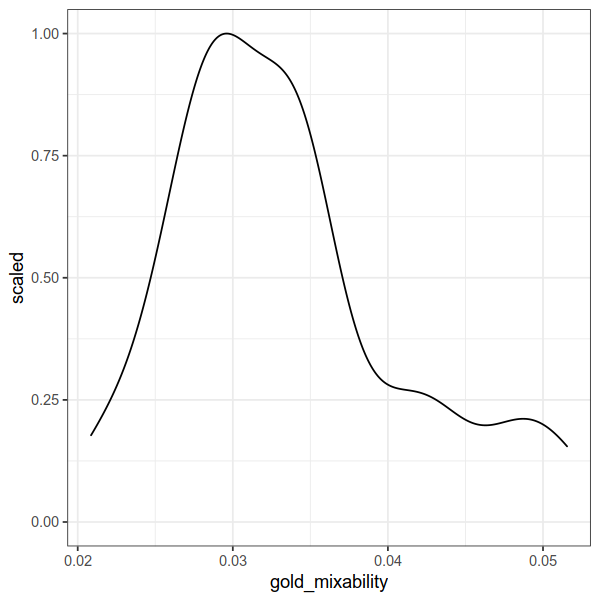

In [113]:
h_ = 5
w_ = 5
options(repr.plot.height=h_, repr.plot.width=w_)

g5<-ggplot(res.df, aes(x=gold_mixability))+ 
# geom_histogram(aes(y = ..ncount..)) + 
   geom_density(aes(y = ..scaled..)) + theme_bw()
g5

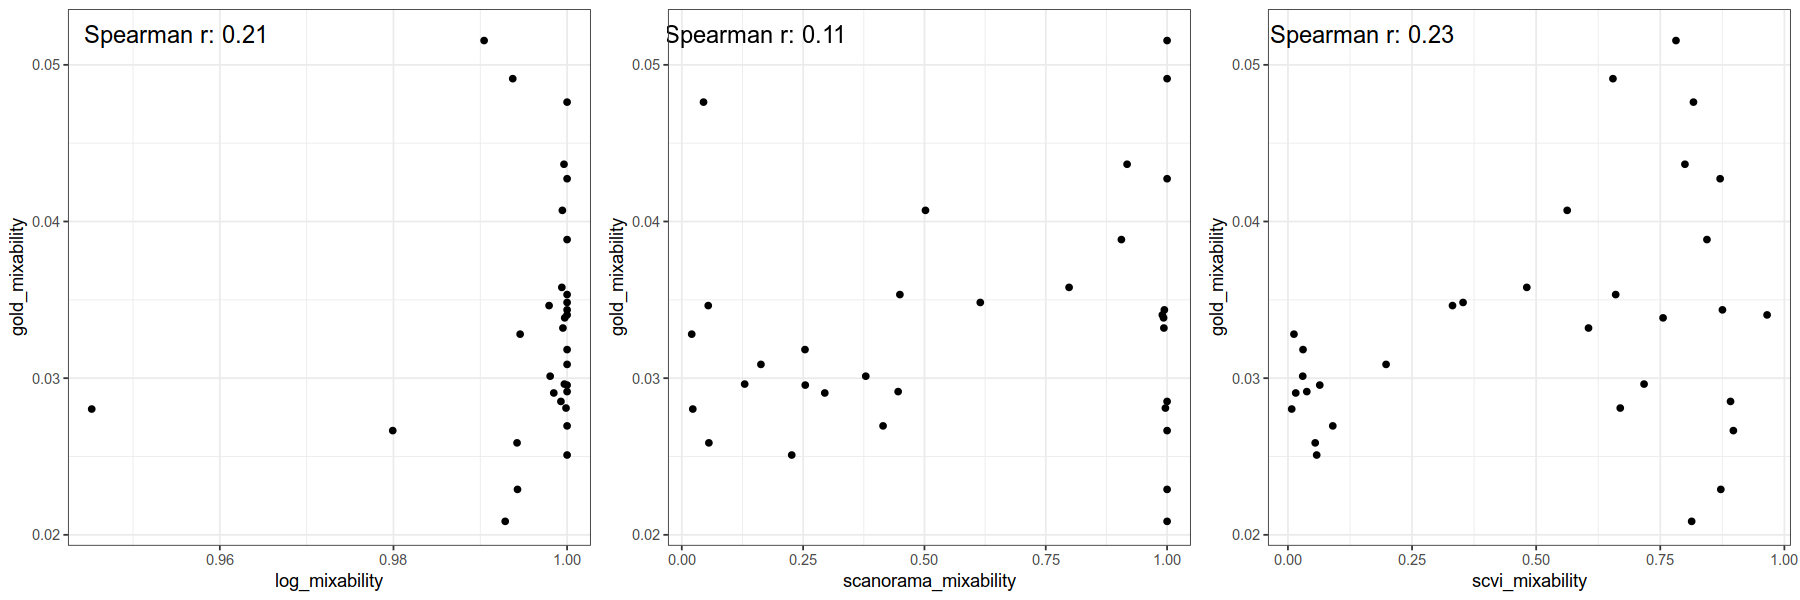

In [127]:
h_ = 5
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

metric<-'log_mixability'
spearmanr<-cor(res.df$gold_mixability, res.df[[metric]], method = 'spearman') 
annotation <- data.frame(x = c(0.955),y = c(0.052), label = paste0('Spearman r: ', format(round(spearmanr, 2), nsmall = 2)))
g6a<-ggplot(res.df, aes(y=gold_mixability, x = log_mixability))+ 
geom_point()+geom_text(data=annotation, aes( x=x, y=y, label=label), size=5)+ theme_bw()+xlab(metric)

metric<-'scanorama_mixability'
spearmanr<-cor(res.df$gold_mixability, res.df[[metric]], method = 'spearman') 
annotation <- data.frame(x = c(0.15),y = c(0.052), label = paste0('Spearman r: ', format(round(spearmanr, 2), nsmall = 2)))
g6b<-ggplot(res.df, aes(y=gold_mixability, x = scanorama_mixability))+ 
geom_point()+geom_text(data=annotation, aes( x=x, y=y, label=label), size=5)+ theme_bw()+xlab(metric)

metric<-'scvi_mixability'
spearmanr<-cor(res.df$gold_mixability, res.df[[metric]], method = 'spearman') 
annotation <- data.frame(x = c(0.15),y = c(0.052), label = paste0('Spearman r: ', format(round(spearmanr, 2), nsmall = 2)))
g6c<-ggplot(res.df, aes(y=gold_mixability, x = scvi_mixability))+ 
geom_point()+geom_text(data=annotation, aes( x=x, y=y, label=label), size=5)+ theme_bw()+xlab(metric)

g6<-ggpubr::ggarrange(g6a, g6b, g6c, ncol = 3)
g6

#### Question 1: How do the various simulation parameters affect batch severity?

In [141]:
res.df[['n.batches']]<-factor(res.df$n.batches, levels = c(2, 4, 5))
res.df[['batch.scale']]<-factor(res.df$batch.scale, levels = sort(unique(res.df$batch.scale)))
res.df[['batch.location']]<-factor(res.df$batch.location, levels = sort(unique(res.df$batch.scale)))

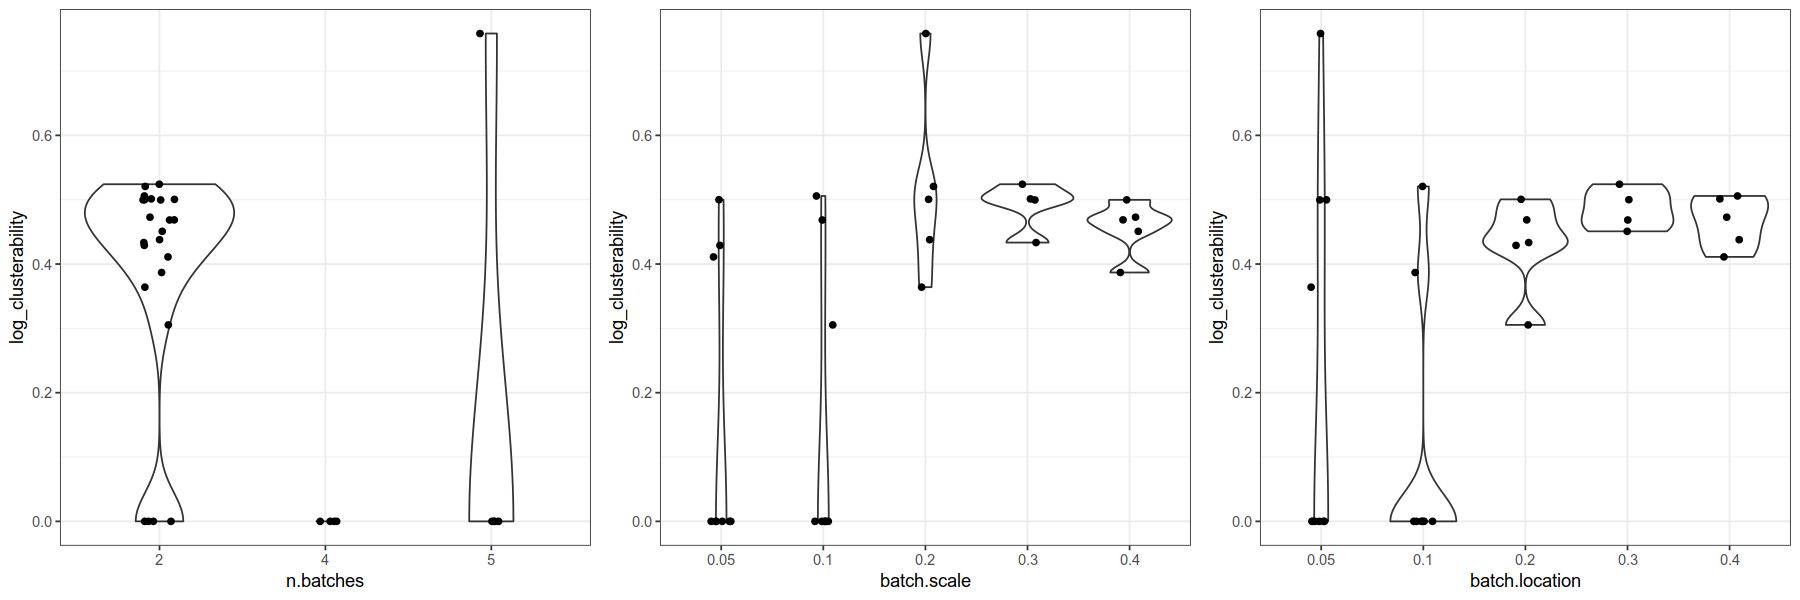

In [143]:
h_ = 5
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

metric<-'log_clusterability'
g7a<-ggplot(res.df, aes(y=log_clusterability, x = n.batches))+ 
geom_violin()+geom_jitter(height = 0, width = 0.1)+theme_bw()

g7b<-ggplot(res.df, aes(y=log_clusterability, x = batch.scale))+ 
geom_violin()+geom_jitter(height = 0, width = 0.1)+theme_bw()

g7c<-ggplot(res.df, aes(y=log_clusterability, x = batch.location))+ 
geom_violin()+geom_jitter(height = 0, width = 0.1)+theme_bw()

g7<-ggpubr::ggarrange(g7a, g7b, g7c, ncol = 3)
g7

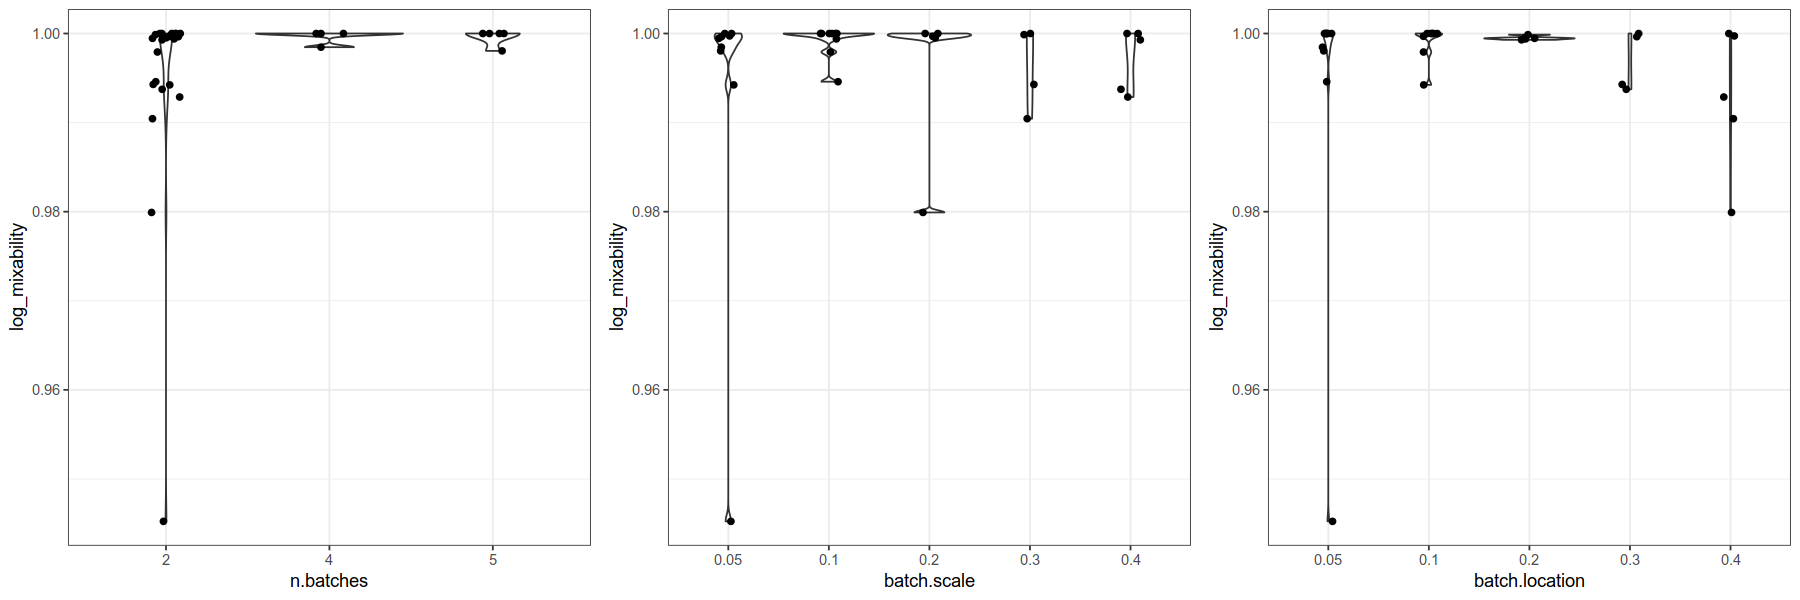

In [145]:
h_ = 5
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

metric<-'log_mixability'
g8a<-ggplot(res.df, aes(y=log_mixability, x = n.batches))+ 
geom_violin()+geom_jitter(height = 0, width = 0.1)+theme_bw()

g8b<-ggplot(res.df, aes(y=log_mixability, x = batch.scale))+ 
geom_violin()+geom_jitter(height = 0, width = 0.1)+theme_bw()

g8c<-ggplot(res.df, aes(y=log_mixability, x = batch.location))+ 
geom_violin()+geom_jitter(height = 0, width = 0.1)+theme_bw()

g8<-ggpubr::ggarrange(g8a, g8b, g8c, ncol = 3)
g8

In [148]:
res.df[res.df$log_clusterability == 0, ]

iteration n.batches batch.scale batch.location gold_clusterability
1   1        2         0.05        0.05           0                  
2   2        2         0.05        0.1            0                  
6   6        2         0.1         0.05           0                  
7   7        2         0.1         0.1            0                  
24 26        4         0.05        0.05           0                  
25 27        4         0.05        0.1            0                  
26 31        4         0.1         0.05           0                  
27 32        4         0.1         0.1            0                  
28 51        5         0.05        0.05           0                  
29 52        5         0.05        0.1            0                  
30 56        5         0.1         0.05           0                  
31 57        5         0.1         0.1            0                  
   gold_mixability log_clusterability log_mixability scanorama_clusterability
1  0.02802935      0                  0.9452411      0                       
2  0.02587002      0                  0.9942348      0                       
6  0.03280922      0                  0.9945912      0                       
7  0.03463312      0                  0.9979245      0                       
24 0.02905462      0                  0.9984664      0                       
25 0.02695378      0                  1.0000000      0                       
26 0.03087866      0                  1.0000000      0                       
27 0.02914226      0                  1.0000000      0                       
28 0.03012579      0                  0.9980503      0                       
29 0.03182390      0                  1.0000000      0                       
30 0.02509434      0                  1.0000000      0                       
31 0.02955882      0                  1.0000000      0                       
   scanorama_mixability ⋯ frac_0.1_corr.index_log_natmi
1  0.02266247           ⋯ 0.9995625                    
2  0.05580713           ⋯ 0.9990763                    
6  0.02046122           ⋯ 0.9991158                    
7  0.05450734           ⋯ 0.9972715                    
24 0.29464286           ⋯ 0.9996577                    
25 0.41472689           ⋯ 0.9995191                    
26 0.16307531           ⋯ 0.9993946                    
27 0.44581590           ⋯ 0.9996360                    
28 0.37907757           ⋯ 0.9997100                    
29 0.25387841           ⋯ 0.9997482                    
30 0.22651992           ⋯ 0.9995698                    
31 0.25441176           ⋯ 0.9994648                    
   frac_0.1_corr.index_scanorama_natmi frac_0.1_corr.index_scvi_natmi
1  0.9950576                           0.9813951                     
2  0.9772911                           0.9820253                     
6  0.9961339                           0.9819495                     
7  0.9951011                           0.9802813                     
24 0.9121375                           0.9829247                     
25 0.9401052                           0.9831834                     
26 0.9667095                           0.9824736                     
27 0.9635599                           0.9825476                     
28 0.9504812                           0.9834176                     
29 0.9566293                           0.9839358                     
30 0.9403218                           0.9832245                     
31 0.9425273                           0.9842539                     
   frac_0.1_corr.index_log_sca frac_0.1_corr.index_scanorama_sca
1  0.9998299                   0.9976023                        
2  0.9997910                   0.9995219                        
6  0.9998059                   0.9992208                        
7  0.9997939                   0.9973903                        
24 0.9998207                   0.9997838                        
25 0.9998146                   0.9997624           

#### Question 2: At what level of batch severity can tensor decomposition no longer recover the signal without batch correction (i.e., just log-normalized)?

In [230]:
bs.df_<-res.df[c('log_clusterability', 'log_mixability', 'frac_0_corr.index_log_natmi', 
               'frac_0_corr.index_log_sca', 'frac_0.1_corr.index_log_natmi', 'frac_0.1_corr.index_log_sca')]

bs.df<-data.frame(matrix(ncol = 5, nrow = 0))
colnames(bs.df)<-c('Clusterability', 'Mixability', 'Similarity', 'Score.Method', 'Expr.Threshold')

for (col_idx in 3:dim(bs.df_)[[2]]){
    col_name<-names(bs.df_)[col_idx]
    entries<-strsplit(col_name, '_')[[1]]
    expr_thresh<-entries[[2]]
    score.method<-entries[[5]]
    
    bs.df.temp<-bs.df_[,1:2]
    colnames(bs.df.temp)<-names(bs.df)[1:2]
    
    bs.df.temp[['Similarity']]<-bs.df_[[col_idx]]
    bs.df.temp[['Score.Method']]<-score.method
    bs.df.temp[['Expr.Threshold']]<-expr_thresh
    
    bs.df<-rbind(bs.df, bs.df.temp)
}

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



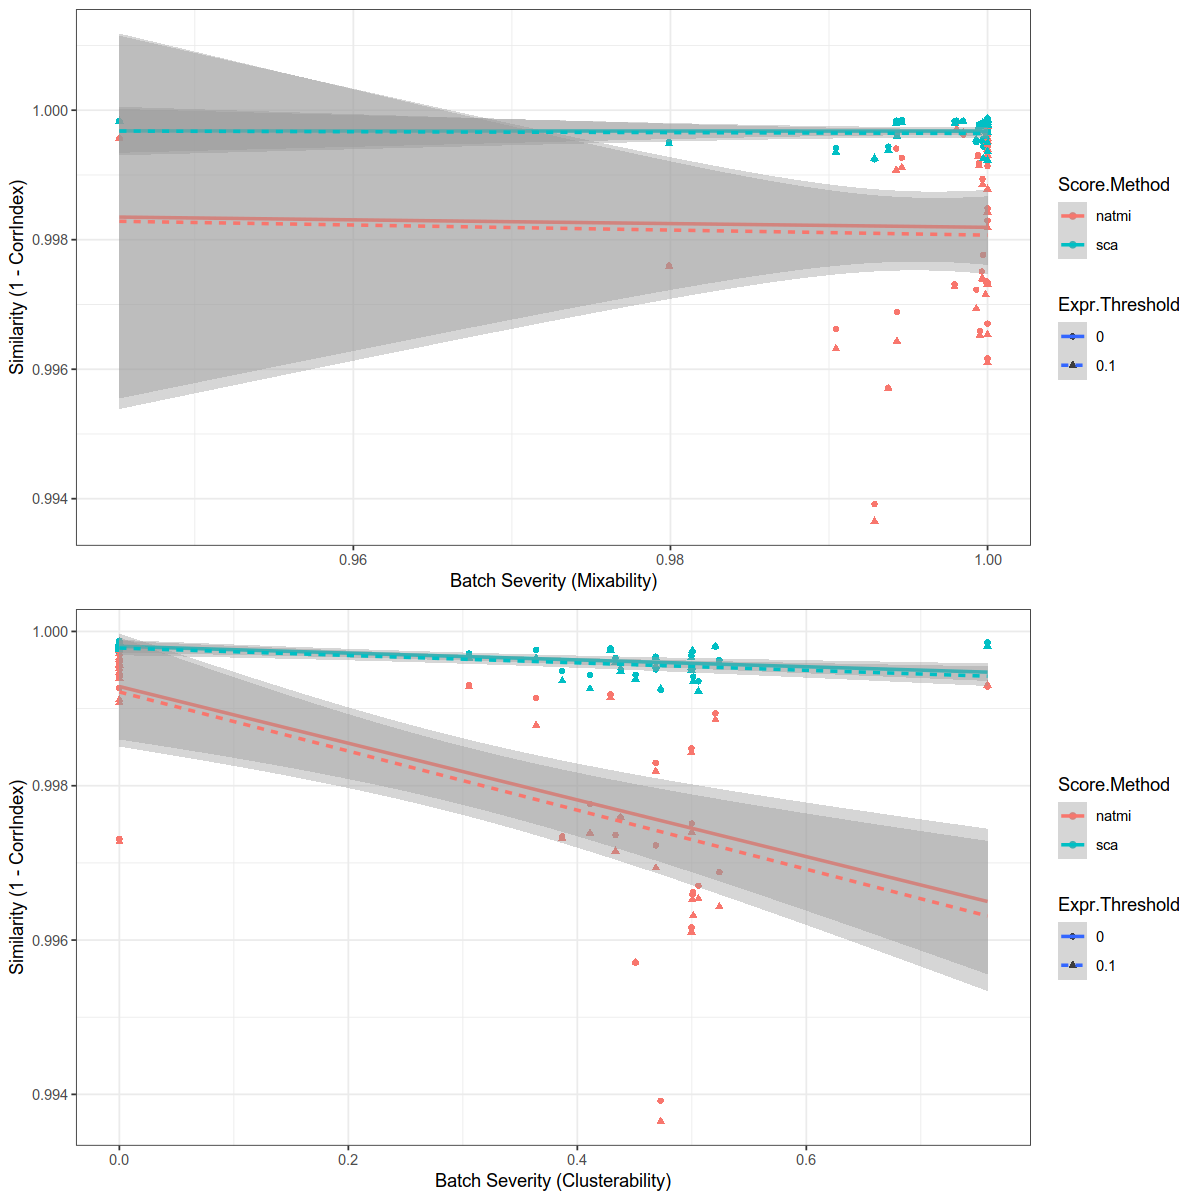

In [268]:
h_ = 10
w_ = 10
options(repr.plot.height=h_, repr.plot.width=w_)

g9a<-ggplot(bs.df, aes(x = Mixability, y = Similarity, color = Score.Method)) + 
    geom_point(aes(shape = Expr.Threshold)) + geom_smooth(method=lm, aes(linetype = Expr.Threshold)) + 
    theme_bw() + ylab('Similarity (1 - CorrIndex)') + xlab('Batch Severity (Mixability)')

bs.df.2<-bs.df[bs.df$Clusterability != 0,]
g9b<-ggplot(bs.df, aes(x = Clusterability, y = Similarity, color = Score.Method)) + 
    geom_point(aes(shape = Expr.Threshold)) + geom_smooth(method=lm, aes(linetype = Expr.Threshold)) + 
    theme_bw() + ylab('Similarity (1 - CorrIndex)') + xlab('Batch Severity (Clusterability)')

g9<-ggpubr::ggarrange(g9a, g9b, ncol = 1)
g9